<a href="https://colab.research.google.com/github/ktichola/ML-and-DL-to-Gravitational-waves-analysis/blob/main/Kyriaki_2_G2NET_Noise_Analysis_Feature_Ext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'g2net-gravitational-wave-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F23249%2F2399555%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240506%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240506T041933Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8f135a8c3bffea3a79febd9adff5d269bbccf69856f1cd464e2d887b17af9924ae4a84f061c498382621ff37094322c67c76f6119349b06e651ad3987d3fbb9831f2b33e95122f8f5f21ab0c7b58e5caac6f8bab90c2119b690f5bf4ffce76212503b9c9c218068021ad8266b38d36c8aa0e3e2c57e8f156e85df2e7e70fd43b49a37ab1df5f928254af7500df856a642daf5985b68e0a84b45d36f740d1c38e3b4dd6d93f39ba81a115cf6f976d2dd2d578df7f0ebb4c637a2c8f16c1aa884a259fabd3b21d32601bf9f3373225206ce37cdd67488ef01a83d3706d750b1996829e589edb62356ddff7508c7a64e43c0fb213763de30b029317a1ffed63eb61'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


References:

https://www.gw-openscience.org/GW150914data/LOSC_Event_tutorial_GW150914.html#Whitening

https://github.com/zerafachris/g2net_2nd_training_school_malta_mar_2020/blob/master/lectures/SP_Signal_Processing_Introduction-Eftim_Zdravevski/signal_processing_2_preparing_GW_data.ipynb



Starter EDA.  There are two bandpass filters, BPF_alias and BPF_strain [2,12].

BPF_alias passband is between low_cut_alias =18Hz and high_cut_alias=1020Hz. The raw signal is scaled up and BPF_alias[42] then it is either with or without removing the average background[17]. The signal is then whiten[41], then BPF_strain. The BPF_strain passband is low_cut_strain=low_cut_alias+5 between high_cut_strain=high_cut_alias-5.

The BPF_alias serves three purposes:
- Low_cut_alias removes the unwanted signal below 18Hz. This increases the dynamic range of the signal, especially down cast to lower precision.
- Scaling up the signal gives the maximum float64 precision.
- High_cut_alias prevents signal freq that is very close to Nyquist from folding back to low frequency.  When the freq is too close to Nyquist, it is difficult to prevent it from aliasing. The only way is to attenuate it. This setting is a trade-off between how much to attenuate the signal and allow aliasing.

After BPF_alias, the signal is whiten.  To whiten the signal, its PSD is obtained and transform the signal into freq-domain by FFT it. The freq-domain signal is amplitude equalized, all the weak/strong amplitudes are equalized to the same level.

After whitening, the signal is BPF_strain to remove the out of band signal again since whitening equalizes it or to narrow the band of interest.  The equalized signal is then transformed back to time-domain by IFFT it.  The 1D-time-domain signal can be used for NN or 2D-spectrogram by FFT the signal segment by segment in time.  The noise analysis is based on a spectrogram by projecting it into frequency-domain and time-domain.

This notebook is about:

- Averaging the background noise(target=0)

- Analyze original raw time/freq domain signal

- Analyze the whiten signal before BPF_strain, aliasing, and Nyquist’s DC
- Remove signal from background noise
- Analyze spectrograms with and without background noise removed.
- Data augmentation
- Feature Extraction

1. Explore Numericals

2. Band Pass Filter

3. Average DF_0 Background Noise

    df0_avg = average(df_0) #original data

    df0_avg_gain = average(df_0 << 79 bits) #apply gain on original data

    df0_avg_bpf = average( BPF(df_0 << 79 bits) ) #Band pass filter

4. Comparing Average DF_0

    4a. Time-domain plot

    comparing df0_avg vs (df0_avg_gain >>79) vs (df_0_avg_bpf>>79)

    4b. Freq-domain plot

    comparing df0_avg vs (df0_avg_gain >>79) vs (df_0_avg_bpf>>79)

5. DF_1 Removed Background Noise

    xt_gbpf = BPF(df_1 <<79) #Band pass filter df_1

    xt_gbpf_bg = xt_gbpf - df0_avg_bpf #Removed background noise

6. Comparing Average DF_1

    6a. Time-domain plot

    comparing x(original) vs (xt_gbpf >>79) vs (xt_gbpf_bg>>79)

    6b. Freq-domain plot

    comparing x(original) vs (xt_gbpf >>79) vs (xt_gbpf_bg>>79)

7. BNS_range

8. Whitening without removing Background Noise

    strain_x_whiten, strain_x_whitenbp = whiten_bpf(x,dt) #with background noise

    x = original data

    strain_x_whiten = whiten(x)

    strain_x_whitenbp = BPF(strain_x_whiten)

9. Comparing whiten data without removing Background Noise

    9a. Time-domain plot

    comparing x(original) vs (strain_x_whiten) vs (strain_x_whitenbp)

    9b. Freq-domain plot

    comparing x(original) vs (strain_x_whiten ) vs (strain_x_whitenbp)

10. Whitening with Removed Background Noise

    strain_x_whiten_nobg, strain_x_whitenbp_nobg = whiten_bpf(x,dt,remove_bg=True)

11. Comparing whiten data with removed Background Noise

12. Data Augmentation

13. Feature Extraction

    13a. Spectrogram Feature Extraction

    13b. Time-domain(1D) Feature Extraction
    
14. Summary

In [ ]:
import os

import numpy as np
from numpy import convolve

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy import signal
from scipy.fftpack import fft
from scipy.signal import butter, filtfilt, freqz, iirdesign, zpk2tf
import scipy as scp
import scipy.stats as sp
from scipy.interpolate import interp1d

import math
import sklearn
import glob

Each data sample (npy file) contains 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

In [ ]:
DEBUG = 1
EPS = 0.00001          #-5dB

#BPF aliasing
lowcut_alias = 18             #Hz, to remove low freq
highcut_alias = 1020          #Hz
fband_alias =[lowcut_alias,highcut_alias]
order_bpf_alias = 6          #filter order
#BPF strain
lowcut = lowcut_alias+5      #23Hz, to remove low freq
highcut = highcut_alias-5    #1015Hz
fband =[lowcut,highcut]
order_bpf = 4                #filter order

fs = 2048                    #sample rate, Hz
nyq = 0.5 * fs               #Nyquist Frequency

In [ ]:
MAIN_DIR = '../input/g2net-gravitational-wave-detection'
TRAIN_DIR = '../input/g2net-gravitational-wave-detection/train'
SUB_DIR = '../input/g2net-gravitational-wave-detection/test'

train = pd.read_csv(MAIN_DIR+'/training_labels.csv')
test = pd.read_csv(MAIN_DIR+'/sample_submission.csv')

In [ ]:
if DEBUG == 1:
    #paths = glob.glob(TRAIN_DIR+"/0/0/*/*")
    paths = glob.glob(TRAIN_DIR+"/0/9/*/*")
else:
    paths = glob.glob(TRAIN_DIR+"/*/*/*/*")

ids = [path.split("/")[-1].split(".")[0] for path in paths]
paths_df = pd.DataFrame({"path":paths, "id": ids})
train_df = pd.merge(left=train, right=paths_df, on="id")

#paths = glob.glob(SUB_DIR+"/*/*/*/*")
#ids = [path.split("/")[-1].split(".")[0] for path in paths]
#paths_df = pd.DataFrame({"path":paths, "id": ids})
#test_df = pd.merge(left=test, right=paths_df, on="id")

train_df.head(2)

,id,target,path
0,090000381f,0,../input/g2net-gravitational-wave-detection/tr...
1,090009b0a9,1,../input/g2net-gravitational-wave-detection/tr...


In [ ]:
train_df.shape

(2132, 3)

In [ ]:
df_0     = train_df[train_df['target']==0]
df_1     = train_df[train_df['target']==1]

#train_df = pd.concat([df_0,df_1])
#train_df = train_df.reset_index()
#test_df = test_df[:31].reset_index(drop=True)

In [ ]:
np.log2(len(df_0)), np.log2(len(df_1))  #19bits

(10.079484783826816, 10.036173612553485)

**1.0 Explore Numericals**

In [ ]:
def numerical_values(dat, gain=1):
    if gain != 1 :                #avoid multiply by 0.9999..
        dat = gain*dat
    dat_min  = np.min(dat)
    dat_max  = np.max(dat)
    dat_mean = np.mean(dat)
    print('len=', len(dat))
    print('min=', dat_min, 'max=',dat_max, 'mean=',dat_mean)

    dat_min_bit = np.log2(abs(dat_min))
    dat_max_bit = np.log2(abs(dat_max))
    dat_mean_bit = np.log2(abs(dat_mean))
    dat_range_bit = np.log2(abs(dat_max-dat_min))
    print('minbit= ',dat_min_bit, 'maxbit= ',dat_max_bit, 'meanbit= ',dat_mean_bit, 'rangebit= ',dat_range_bit )
    return dat_mean

In [ ]:
#import sys
#sys.float_info
np.finfo("float64")

finfo(resolution=1e-15, min=-1.7976931348623157e+308, max=1.7976931348623157e+308, dtype=float64)

In [ ]:
print('closest value to 0 =', np.finfo("float64").tiny, 'smallest value=', 2**-1074, 'smallest round to 0= ',2**-1075)

closest value to 0 = 2.2250738585072014e-308 smallest value= 5e-324 smallest round to 0=  0.0


In [ ]:
#Checking numerical values
#LIGO averaged measured noise amplitude of about 10^-23 at 100 Hz, Virgo it is 5 × 10^-24 at 100 Hz
#gain_ref_ligo = 1/(4*10**-24)
#gain_ref_virgo = 1/(5*10**-24)
gain_min = 2**int(np.log2(1/10**-23))  #power of 2 gain, <<76bits
gain_ref = 2**int(np.log2(1/10**-24))  # <<79 bits
gain_max = 2**int(np.log2(1/10**-25))  # <<83 bits

file_path = df_0.iloc[0]["path"]
dat_raw  =  np.load(file_path)

#H1 - LIGO
gain_ligo_H1 = 1.0
dat_mean = numerical_values(dat_raw[0,], gain_ligo_H1)
#gain_ligo_H1 = 1/np.abs(dat_mean)  #
#gain_ligo_H1 = 2**( int( np.log2(gain_ligo_H1)) )
dat_mean = numerical_values(dat_raw[0,], gain_ref)  #use reference gain for all, <<79

#L1 - LIGO
gain_ligo_L1 = 1.0
dat_mean = numerical_values(dat_raw[1,], gain_ligo_L1)
#gain_ligo_L1 = 1/np.abs(dat_mean)  #
#gain_ligo_L1 = 2**( int( np.log2(gain_ligo_L1)) )
dat_mean = numerical_values(dat_raw[1,], gain_ref)  #use reference gain for all, <<79

#V1 - VIRGO
gain_virgo_V1 = 1.0
dat_mean = numerical_values(dat_raw[2,], gain_virgo_V1)
#gain_virgo_V1 = 1/np.abs(dat_mean)  #
#gain_virgo_V1 = 2**( int( np.log2(gain_virgo_V1)) )
dat_mean = numerical_values(dat_raw[2,], gain_ref)  #use reference gain for all, <<79

len= 4096
min= -2.2798962050052023e-20 max= 2.1495165988154174e-20 mean= -5.444544740630961e-23
minbit=  -65.24959375227515 maxbit=  -65.33454964672529 meanbit=  -73.95953476301597 rangebit=  -64.29144644076503
len= 4096
min= -13781.126941360984 max= 12993.030579990893 mean= -32.9102535649795
minbit=  13.750406247724849 maxbit=  13.665450353274702 meanbit=  5.0404652369840575 rangebit=  14.708553559234968
len= 4096
min= -2.178271594334136e-20 max= 2.2220061737320957e-20 mean= -8.261594271367488e-23
minbit=  -65.31537805233762 maxbit=  -65.28669907255926 meanbit=  -73.35792597153254 rangebit=  -64.30096730082386
len= 4096
min= -13166.843862618302 max= 13431.2031738392 mean= -49.938273129182676
minbit=  13.684621947662377 maxbit=  13.713300927440741 meanbit=  5.6420740284674755 rangebit=  14.699032699176142
len= 4096
min= -4.081023456681816e-21 max= 3.829277103775516e-21 mean= -1.0940934184998158e-23
minbit=  -67.73155898977168 maxbit=  -67.82341792874385 meanbit=  -76.27461025538267 ran

**2. Band Pass Filter**

2a. Band Pass(Butterworth) Filter

512


Text(0.5, 1.0, 'Zoom-In BPF')

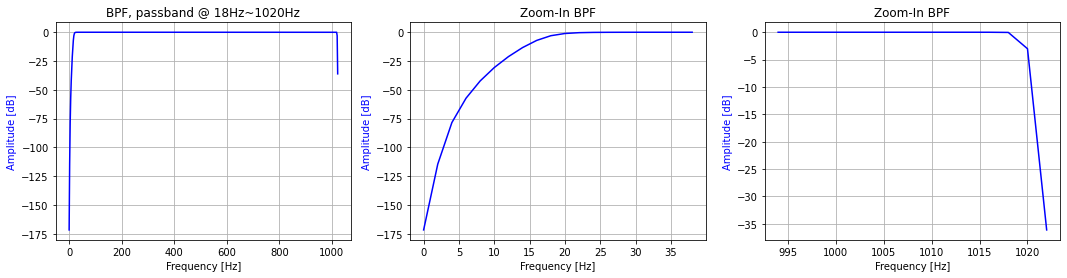

In [ ]:
def butter_bandpass_filter(data, cutoff_low, cutoff_high, fs, order):
    normal_cutoff_low = cutoff_low / nyq
    normal_cutoff_high = cutoff_high / nyq
    # Get the filter coefficients
    # bb, ab = butter(6, [80*2./fs, 500*2./fs], btype='band')
    b, a = butter(order, [normal_cutoff_low,normal_cutoff_high], btype='band', analog=False)
    y = filtfilt(b, a, data)
    return y


#BandPass Filter Frequency Response
b2, a2 = butter(order_bpf_alias, [lowcut_alias/nyq, highcut_alias/nyq], btype='band', analog=False)
w2,h2 = freqz(b2,a2, fs=fs)
print(len(w2))  #len(w2) = 1024Hz

plt.figure(figsize=(18,4))
plt.subplot(131)
plt.plot(w2, 20 * np.log10(abs(h2)+2**-31), 'b')  #add 2**-31 to avoid log(0)
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.title('BPF, passband @ 18Hz~1020Hz')

bins=20   # 40Hz = 20*1024/len(w2)
plt.subplot(132)
plt.plot(w2[:bins], 20 * np.log10(abs(h2[:bins])+2**-31), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.title('Zoom-In BPF')

bins=15  # -30Hz = 15*1024/len(w2)
plt.subplot(133)
plt.plot(w2[-bins:], 20 * np.log10(abs(h2[-bins:])+2**-31), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.grid()
plt.title('Zoom-In BPF')

2b. Band Pass and Notch Filters

In [ ]:
#https://www.uv.es/virgogroup/Denoising_ROF.html

#This filtering method consists in detecting the known spectral lines
#(e.g. frequency of the normal modes of vibration of the suspended mirrors,
#frequency of the electric network, etc) to remove them from the data.

def iir_bandstops(fstops, fs, order=4):
    """ellip notch filter
    fstops is a list of entries of the form [frequency (Hz), df, df2]
    where df is the pass width and df2 is the stop width (narrower
    than the pass width). Use caution if passing more than one freq at a time,
    because the filter response might behave in ways you don't expect.
    """
    nyq = 0.5 * fs

    # Zeros zd, poles pd, and gain kd for the digital filter
    zd = np.array([])
    pd = np.array([])
    kd = 1

    # Notches
    for fstopData in fstops:
        fstop = fstopData[0]
        df = fstopData[1]
        df2 = fstopData[2]
        low = (fstop - df) / nyq
        high = (fstop + df) / nyq
        low2 = (fstop - df2) / nyq
        high2 = (fstop + df2) / nyq
        z, p, k = iirdesign([low,high], [low2,high2], gpass=1, gstop=6,
                            ftype='ellip', output='zpk')
        zd = np.append(zd,z)
        pd = np.append(pd,p)

    # Set gain to one at 100 Hz...better not notch there
    bPrelim,aPrelim = zpk2tf(zd, pd, 1)
    outFreq, outg0 = freqz(bPrelim, aPrelim, 100/nyq)

    # Return the numerator and denominator of the digital filter
    b,a = zpk2tf(zd,pd,k)
    return b, a


def get_filter_coefs(fs):
#def get_filter_coefs():

    # assemble the filter b,a coefficients:
    coefs = []

    # bandpass filter parameters
    #lowcut=43
    #highcut=1023  #2047
    #order = 4

    # bandpass filter coefficients
    #nyq = 0.5*fs
    #low = lowcut / nyq
    #high = highcut / nyq
    #bb, ab = butter(order, [low, high], btype='band')
    #coefs.append((bb,ab))

    # Frequencies of notches at known instrumental spectral line frequencies.
    # You can see these lines in the ASD above, so it is straightforward to make this list.
    notchesAbsolute = np.array(
        [14.0,34.70, 35.30, 35.90, 36.70, 37.30, 40.95, 60.00,
         120.00, 179.99, 304.99, 331.49, 510.02, 1009.99])

    # notch filter coefficients:
    for notchf in notchesAbsolute:
        bn, an = iir_bandstops(np.array([[notchf,1,0.1]]), fs, order=4)
        coefs.append((bn,an))

    # Manually do a wider notch filter around 510 Hz etc.
    bn, an = iir_bandstops(np.array([[510,200,20]]), fs, order=4)
    coefs.append((bn, an))

    # also notch out the forest of lines around 331.5 Hz
    bn, an = iir_bandstops(np.array([[331.5,10,1]]), fs, order=4)
    coefs.append((bn, an))

    return coefs

# Find the coefficients
notch_coefs = get_filter_coefs(fs)


def notch_filter_data(data_in,coefs):
    data = data_in.copy()
    for coef in coefs:
        b,a = coef
        # filtfilt applies a linear filter twice, once forward and once backwards.
        # The combined filter has linear phase.
        data = filtfilt(b, a, data)
    return data

**3. Average DF_0 Background Noise**

In [ ]:
avg_sample = np.power(2,9)  #512
max_31bit  = np.power(2,30)-1  #2**30-1

def avg_data(df,gain,bpf,noise=np.array([])):
    max_abs = np.full(3, -np.inf)

    if gain == 1:
        avg_df  = np.zeros((3,4096), dtype = np.float64)  #
        if(noise.size == 0):
            noise   = np.zeros((3,4096), dtype = np.float64)  # background-noise
    else:
        avg_df  = np.zeros((3,4096), dtype = np.float32)  #
        if(noise.size == 0):
            noise   = np.zeros((3,4096), dtype = np.float32)  # background-noise
    for i,fn in enumerate(df.path[:avg_sample]):
        dat_raw   = np.load(fn)                           #3x4096
        if gain != 1:  #avoid multiply by 0.99...
            dat_raw   = gain*dat_raw                      # <<79 bits


        for k in range( len(avg_df) ):
            if bpf:
                dat_raw[k,] = butter_bandpass_filter(dat_raw[k,], lowcut_alias, highcut_alias, fs, order=6)  #aliasing filter
                #dat_raw[k,] = butter_bandpass_filter(dat_raw[k,], lowcut_alias, highcut_alias, fs, order=6)  #serialize double the attenuation

            if i == 0:
                avg_df[k,] = dat_raw[k,] - noise[k,]  #remove background noise
            else:
                avg_df[k,] = avg_df[k,] + dat_raw[k,] - noise[k,]  #remove background noise


            if(i%200 == 0):
                dat_min=np.min(avg_df[k,])
                dat_max=np.max(avg_df[k,])
                dat_mean=np.mean(avg_df[k,])
                max_abs_i = max( np.abs(dat_min), np.abs(dat_max))

                if max_abs_i > max_abs[k] :
                    max_abs[k] = max_abs_i

                print(k, dat_min, dat_max, dat_mean, max_abs[k])

                if ( max_abs[k] > max_31bit):
                    print(k,'close to fixed-point overflow')

    avg_df = avg_df/(i+1)
    return avg_df

In [ ]:
df0_avg = avg_data(df_0, gain=1,bpf=False)         #float64

0 -2.2798962050052023e-20 2.1495165988154174e-20 -5.444544740630961e-23 2.2798962050052023e-20
1 -2.178271594334136e-20 2.2220061737320957e-20 -8.261594271367488e-23 2.2220061737320957e-20
2 -4.081023456681816e-21 3.829277103775516e-21 -1.0940934184998158e-23 4.081023456681816e-21
0 -3.5758917008101344e-19 3.625783550564074e-19 1.2529109588249434e-21 3.625783550564074e-19
1 -2.2276487910209417e-19 2.301697899713208e-19 -1.4863019182139767e-21 2.301697899713208e-19
2 -5.776496837152802e-20 5.885057851405064e-20 1.6020160280342512e-22 5.885057851405064e-20
0 -3.1205758551087445e-19 3.1385805103686876e-19 1.3561836208911873e-22 3.625783550564074e-19
1 -3.8147071070837066e-19 3.785420158125956e-19 -2.943729677316937e-21 3.8147071070837066e-19
2 -1.1385344183377056e-19 1.0240355782597879e-19 3.048358753885566e-22 1.1385344183377056e-19


In [ ]:
#BPF_alias OFF
df0_avg_gain = avg_data(df_0, gain_ref,bpf=False)  #float32

0 -13781.127 12993.03 -32.910255 13781.126953125
1 -13166.844 13431.203 -49.938225 13431.203125
2 -2466.8274 2314.656 -6.613386 2466.827392578125
0 -216149.45 219165.14 757.33826 219165.140625
1 -134653.17 139129.14 -898.4142 139129.140625
2 -34916.777 35572.996 96.83592 35572.99609375
0 -188627.19 189715.55 81.97554 219165.140625
1 -230584.92 228814.61 -1779.3752 230584.921875
2 -68820.22 61899.145 184.26208 68820.21875


In [ ]:
#BPF_alias ON
df0_avg_bpf = avg_data(df_0, gain_ref, bpf=True)  #float32

0 -447.7215 418.55334 -0.35883367 447.72149658203125
1 -471.63736 426.1287 -1.9243681 471.6373596191406
2 -517.0566 524.01624 -0.6488691 524.0162353515625
0 -10826.397 17585.436 60.511013 17585.435546875
1 -5352.4463 5464.5605 -11.053666 5464.560546875
2 -7415.8545 6941.0938 12.427172 7415.8544921875
0 -16390.334 24279.266 87.5941 24279.265625
1 -11934.488 9291.715 -42.959766 11934.48828125
2 -12879.5625 14039.212 2.1484642 14039.2119140625


In [ ]:
np.shape(df0_avg), df0_avg.dtype, df0_avg_gain.dtype, df0_avg_bpf.dtype

((3, 4096), dtype('float64'), dtype('float32'), dtype('float32'))

In [ ]:
max_raw = np.abs(np.max(df0_avg))
min_raw = np.abs(np.min(df0_avg))
abs_max = max( max_raw, min_raw )
np.log2(min_raw),np.log2(max_raw),np.log2(np.abs(np.mean(df0_avg))),10*np.log10(abs_max-np.abs(np.mean(df0_avg)))

(-69.88288397595974, -69.8337608900869, -78.8836978549239, -210.22876885196303)

In [ ]:
max_g = np.abs(np.max(df0_avg_gain))
min_g = np.abs(np.min(df0_avg_gain))
abs_max_gain = max(max_g,min_g)
np.log2(min_g),np.log2(max_g),np.log2(np.abs(np.mean(df0_avg_gain))),10*np.log10(abs_max_gain-np.abs(np.mean(df0_avg_gain)))

(9.117115, 9.16624, 0.116301596, 27.58492946624756)

In [ ]:
max_b = np.abs(np.max(df0_avg_bpf))
min_b = np.abs(np.min(df0_avg_bpf))
abs_max_b = max(max_b,min_b)
np.log2(min_b),np.log2(max_b),np.log2(np.abs(np.mean(df0_avg_bpf))),10*np.log10(abs_max_b-np.abs(np.mean(df0_avg_bpf)))

(5.1789503, 5.6483417, -4.419412, 16.999154090881348)

In [ ]:
def plot_time_domain_dat(xt, xtgbpf, xtgbpf_bg):
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(24,12))
    all_ones = np.ones(np.shape(xt)[1])
    #overlay plots of average without gain float64, avg with gain<<79 float32, avg with gain<<79+BPF float32
    ax[0,0].plot(xt[0,],'b')                  #H1
    ax[0,0].plot(xtgbpf[0,], 'r--')     #inverse gain >>79bits for comparing
    ax[0,0].plot(xtgbpf_bg[0,], 'g--')  #inverse gain >>79bits for comparing
    ax[1,0].plot(xt[1,],'b')                  #L1
    ax[1,0].plot(xtgbpf[1,], 'r--')     #inverse gain >>79bits for comparing
    ax[1,0].plot(xtgbpf_bg[1,], 'g--')  #inverse gain >>79bits for comparing
    ax[2,0].plot(xt[2,],'b')                  #V1
    ax[2,0].plot(xtgbpf[2,], 'r--')     #inverse gain >>79bits for comparing
    ax[2,0].plot(xtgbpf_bg[2,], 'g--')  #inverse gain >>79bits for comparing
    ax[0,0].legend(['H1','H1<<79','H1_bpf'])
    ax[1,0].legend(['L1','L1<<79','L1_bpf'])
    ax[2,0].legend(['V1','V1<<79','V1_bpf'])

    #average with gain<<79, float32
    ax[0,1].plot(xtgbpf[0,],'r')             #H1
    ax[0,1].plot(all_ones*np.mean(xtgbpf[0,]),'k')
    ax[1,1].plot(xtgbpf[1,],'r')             #L1
    ax[1,1].plot(all_ones*np.mean(xtgbpf[1,]),'k')
    ax[2,1].plot(xtgbpf[2,],'r')             #V1
    ax[2,1].plot(all_ones*np.mean(xtgbpf[2,]),'k')
    ax[0,1].legend(['H1<<79','mean'])
    ax[1,1].legend(['L1<<79','mean'])
    ax[2,1].legend(['V1<<79','mean'])
    #average with gain<<79 + BPF, float32
    ax[0,2].plot(xtgbpf_bg[0,],'g')              #H1
    ax[0,2].plot(all_ones*np.mean(xtgbpf_bg[0,]),'k')
    ax[1,2].plot(xtgbpf_bg[1,],'g')              #L1
    ax[1,2].plot(all_ones*np.mean(xtgbpf_bg[1,]),'k')
    ax[2,2].plot(xtgbpf_bg[2,],'g')              #V1
    ax[2,2].plot(all_ones*np.mean(xtgbpf_bg[2,]),'k')
    ax[0,2].legend(['H1_bpf','mean'])
    ax[1,2].legend(['L1_bpf','mean'])
    ax[2,2].legend(['V1_bpf','mean'])
    return

**4. Comparing Average DF_0**

4a. Time-domian plot

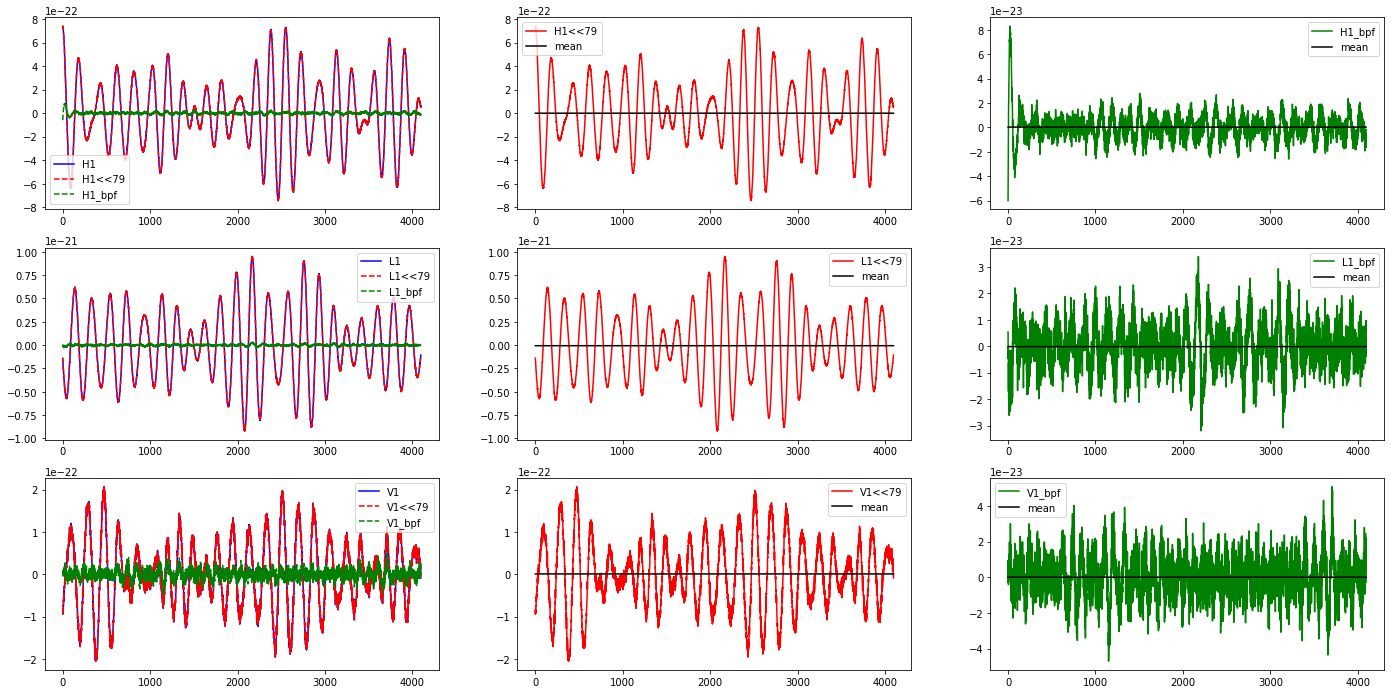

In [ ]:
plot_time_domain_dat(df0_avg, df0_avg_gain/gain_ref, df0_avg_bpf/gain_ref)  #scale-down for comparison

In [ ]:
def gen_psds(x):
    s_H1 = x[0,]
    s_L1 = x[1,]
    s_V1 = x[2,]
    # number of sample for the fast fourier transform:
    #NFFT = 1*fs
    NFFT = 2 * fs           # Use 2 seconds of data for each fourier transform
    NOVL = 1 * NFFT / 2     # The number of points of overlap between segments used in Tukey averaging
    psd_window = scp.signal.tukey(NFFT, alpha=1./4)

    #Tukey window
    Pxx_H, f_ = mlab.psd(s_H1, Fs = fs, NFFT = NFFT,window=psd_window, noverlap=NOVL)
    Pxx_L, f_ = mlab.psd(s_L1, Fs = fs, NFFT = NFFT,window=psd_window, noverlap=NOVL)
    Pxx_V, f_ = mlab.psd(s_V1, Fs = fs, NFFT = NFFT,window=psd_window, noverlap=NOVL)

    # We will use interpolations of the PSDs computed above for whitening:
    psd_H = interp1d(f_, Pxx_H)
    psd_L = interp1d(f_, Pxx_L)
    psd_V = interp1d(f_, Pxx_V)

    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.
    Pxx_ref = (1.e-22*(18./(0.1+f_))**2)**2+0.7e-23**2+((f_/2000.)*4.e-23)**2
    psd_smth = interp1d(f_, Pxx_ref)

    return Pxx_H,Pxx_L,Pxx_V,f_, psd_H,psd_L,psd_V,Pxx_ref,psd_smth


def plot_psd(xt, xt_gain, xt_bpf, f_min_plt=1,f_max_plt=1024,y_min=1e-27,y_max = 1e-19):
    '''
    return xt PSD
    '''
    # plot the ASDs, with the template overlaid:
    f_min = f_min_plt #20.
    f_max = f_max_plt #2000.
    s_min = y_min
    s_max = y_max

    plt.figure(figsize=(20,8))
    plt.subplot(1,3,1)
    Pxx_H1,Pxx_L1,Pxx_V1,freqs_,psd_H1,psd_L1,psd_V1,Pxx,psd_smooth = gen_psds(xt)
    plt.loglog(freqs_, np.sqrt(Pxx_H1),'b',label='H1 strain')
    plt.loglog(freqs_, np.sqrt(Pxx_L1),'r',label='L1 strain')
    plt.loglog(freqs_, np.sqrt(Pxx_V1),'g',label='V1 strain')
    plt.loglog(freqs_, np.sqrt(Pxx),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, s_min, s_max])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain (linear)')

    plt.subplot(1,3,2)
    Pxx_g_H1,Pxx_g_L1,Pxx_g_V1,freqs_g,psd_g_H1,psd_g_L1,psd_g_V1,Pxx_g,psd_smooth_g = gen_psds(xt_gain)

    plt.loglog(freqs_g, np.sqrt(Pxx_g_H1),'b',label='H1 strain')
    plt.loglog(freqs_g, np.sqrt(Pxx_g_L1),'r',label='L1 strain')
    plt.loglog(freqs_g, np.sqrt(Pxx_g_V1),'g',label='V1 strain')
    plt.loglog(freqs_g, np.sqrt(Pxx_g),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, s_min, s_max])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain <<gain (linear)')

    plt.subplot(1,3,3)
    Pxx_bpf_H1,Pxx_bpf_L1,Pxx_bpf_V1,freqs_b,psd_b_H1,psd_b_L1,psd_b_V1,Pxx_b,psd_smooth_b = gen_psds(xt_bpf)
    plt.loglog(freqs_b, np.sqrt(Pxx_bpf_H1),'b',label='H1 strain')
    plt.loglog(freqs_b, np.sqrt(Pxx_bpf_L1),'r',label='L1 strain')
    plt.loglog(freqs_b, np.sqrt(Pxx_bpf_V1),'g',label='V1 strain')
    plt.loglog(freqs_b, np.sqrt(Pxx_b),'k',label='H1 strain, O1 smooth model')
    plt.axis([f_min, f_max, s_min, s_max])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')
    plt.title('Advanced LIGO strain <<gain+bpf (linear)')
    #plt.savefig(eventname+'_ASDs.'+plottype)

    return freqs_,Pxx_H1,Pxx_L1,Pxx_V1,psd_H1,psd_L1,psd_V1

4b. Freq-domain plot

In [ ]:
freqs,Pxx_H1,Pxx_L1,Pxx_V1,psd_H1,psd_L1,psd_V1 = plot_psd(df0_avg, df0_avg_gain/gain_ref, df0_avg_bpf/gain_ref)  #scale-down >>79 for comparison

In [ ]:
#Zoom-In
fmin=10   #Hz
fmax=1024 #Hz
ymin=1e-26
ymax=1e-21
freqs,Pxx_H1,Pxx_L1,Pxx_V1,psd_H1,psd_L1,psd_V1 = plot_psd(df0_avg, df0_avg_gain/gain_ref, df0_avg_bpf/gain_ref,fmin,fmax,ymin,ymax)

In [ ]:
df = freqs[2]-freqs[1]
#spike at H1 and L1 around 300Hz -> bin = 300/0.5 = 600
spike_h1_bg = np.sqrt(Pxx_H1[550:650]).max()
spike_l1_bg = np.sqrt(Pxx_L1[550:650]).max()
spike_v1_bg = np.sqrt(Pxx_V1[550:650]).max()
bin_spike_h1_bg = np.argmax(np.sqrt(Pxx_H1)==spike_h1_bg)
bin_spike_l1_bg =np.argmax(np.sqrt(Pxx_L1)==spike_l1_bg)
bin_spike_v1_bg =np.argmax(np.sqrt(Pxx_V1)==spike_v1_bg)

print('bin h1=',bin_spike_h1_bg,'(',bin_spike_h1_bg*df,'Hz), spike h1=', spike_h1_bg)
print('bin l1=',bin_spike_l1_bg,'(',bin_spike_l1_bg*df,'Hz), spike l1=', spike_l1_bg)
print('bin v1=',bin_spike_v1_bg,'(',bin_spike_v1_bg*df,'Hz), spike v1=', spike_v1_bg)

Blue = H1, Red = L1, Green = V1, Black = O1 smooth Model

Notice that the L1 has either a very strong vibration of the suspended mirrors spike (305Hz) or from the entire data set of event GW. df0_avg is averaged over 512 samples = 512*2/60 = 17 mins. If each sub-folder is at the proximity of time prior or after the GW event, it can represent a non-stationary background noise.


https://www.gw-openscience.org/static/speclines/o2/comb_list_O2V_pers0.3_commented.txt

![image.png](attachment:681546e5-a207-427c-a337-e583817621cf.png)

Below f_min = 20 Hz, the data are not properly calibrated. The noise is so high below f_min that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.


In [ ]:
gw_ids_0=['0980247101']                             #target=0
gw_ids_1=['00000e74ad','0920c46762','098a464da9' ]  #target=1

#run_id = gw_ids_1[0]
#file_path=[MAIN_DIR+'/train/0/0/0/'+run_id+'.npy']

run_id = gw_ids_1[2]
file_path=[MAIN_DIR+'/train/0/9/8/'+run_id+'.npy']

target = train_df[train_df['id']==run_id].target    #set paths accordingly

x  =  np.load(file_path[0])

target

In [ ]:
#Load DF_1 data
'''
i=0
file_path = df_1.iloc[i]["path"]
f_id = df_1.iloc[i]["id"]
target = df_1.iloc[i]["target"]

f_id, target

x  =  np.load(file_path)
'''

**5. DF_1 Removed Background Noise**

In [ ]:
#remove df_1 background noise
#if a signal is periodic and stationary, then the noise can be averaged down
#if a signal is random, it's hard to say, it can be the same as background noise
#df1_avg_bpf = avg_data(df_1, gain_ref, bpf=True, df0_avg_bpf)  #This is over the entire dataset

#gain+bpf
x2_H1_gbpf = butter_bandpass_filter(x[0,]*gain_ref, lowcut_alias, highcut_alias, fs, order=6)  #bandpass filter
x2_L1_gbpf = butter_bandpass_filter(x[1,]*gain_ref, lowcut_alias, highcut_alias, fs, order=6)  #bandpass filter
x2_V1_gbpf = butter_bandpass_filter(x[2,]*gain_ref, lowcut_alias, highcut_alias, fs, order=6)  #bandpass filter

#gain+bpf-background
x2_H1_gbpf_bg = x2_H1_gbpf - df0_avg_bpf[0,] #bandpass filter - background
x2_L1_gbpf_bg = x2_L1_gbpf - df0_avg_bpf[1,] #bandpass filter - background
x2_V1_gbpf_bg = x2_V1_gbpf - df0_avg_bpf[2,] #bandpass filter - background

xt_gbpf     = np.zeros((3,4096), dtype = np.float64)  #
xt_gbpf_bg  = np.zeros((3,4096), dtype = np.float64)  #

xt_gbpf[0,],xt_gbpf[1,],xt_gbpf[2,]          = x2_H1_gbpf, x2_L1_gbpf, x2_V1_gbpf
xt_gbpf_bg[0,],xt_gbpf_bg[1,],xt_gbpf_bg[2,] = x2_H1_gbpf_bg, x2_L1_gbpf_bg, x2_V1_gbpf_bg

In [ ]:
x[0,:3],xt_gbpf[0,:3],xt_gbpf_bg[0,:3],x[1,:3],xt_gbpf[1,:3],xt_gbpf_bg[1,:3],x[2,:3],xt_gbpf[2,:3],xt_gbpf_bg[2,:3]

For this 2 seconds instance, there is no significant difference between BPF vs (BPF-Background).

**6. Comparing Average DF_1**

6a. Time-domian plot

In [ ]:
plot_time_domain_dat(x,xt_gbpf/gain_ref ,xt_gbpf_bg/gain_ref)     #scale down for comparison
#plot_time_domain_dat(x*gain_ref, xt_gbpf ,xt_gbpf_bg)            #scale up

Left figure, since BPF removed the high amplitude low freq noise, the amplitude of BPF outputs are much smaller compared to unfilter original signal.

Middle and right figures, at ringdown, a sharp decrease in amplitude is like an impulse, this will create a transient with very high frequencies.

ring down peak at 2*(3434/4096) = 1.677 sec

In [ ]:
if (run_id == '098a464da9'):
    #Ring-down
    plt.figure(figsize=(20,4))
    plt.plot(xt_gbpf[0,3150:3550])
    plt.plot(xt_gbpf[1,3150:3550])
    plt.plot(xt_gbpf[2,3150:3550])
    plt.legend(['H1','L1','V1'])
    plt.xticks(np.arange(0,400,10))
    plt.grid()

In [ ]:
if (run_id == '098a464da9'):
    #find peaks, time-domain corr is more accurate
    h1_pk=np.argmax(np.abs(xt_gbpf[0,3150:3550]))
    l1_pk=np.argmax(np.abs(xt_gbpf[1,3150:3550]))
    v1_pk=np.argmax(np.abs(xt_gbpf[2,3150:3550]))

    #freq at sample 3150,  0.1387 sec prior to ringdown (H1)
    f_h1_3150 = fs/60  #60 samples in one period
    f_l1_3150 = fs/60
    f_v1_3150 = fs/60

    #max freq, last cycle prior to ringdown
    f_h1_max = fs/(h1_pk-264)
    f_l1_max = fs/(l1_pk-271)
    f_v1_max = fs/(v1_pk-316)

    #count 4 cycles before and after their peaks,
    h1_4cycles_before = h1_pk-162  #samples
    l1_4cycles_before = l1_pk-180  #samples
    v1_4cycles_before = v1_pk-215  #samples
    #4 cycles after peaks
    h1_4cycles_after = 318-h1_pk  #samples
    l1_4cycles_after = 318-l1_pk  #samples
    v1_4cycles_after = 368-v1_pk  #samples
    print('h1_peak=',h1_pk,' l1_peak=',l1_pk,' v1_peak=',v1_pk)
    #h1_pk,l1_pk,v1_pk,h1_4cycles_before,l1_4cycles_before,v1_4cycles_before,h1_4cycles_after,l1_4cycles_after,v1_4cycles_after

In [ ]:
if (run_id == '098a464da9'):
    #ramp-up dominant freq at sample 3150, 284/2048 = 0.1387 sec prior to ringdown(H1)
    print('dominant freq at sample 3150 H1 =',f_h1_3150,'(Hz)')
    print('dominant freq at sample 3150 L1 =',f_l1_3150,'(Hz)')
    print('dominant freq at sample 3150 V1 =',f_v1_3150,'(Hz)')
    print('')
    print('dominant max freq  H1 =',f_h1_max,'(Hz)')
    print('dominant max freq  L1 =',f_l1_max,'(Hz)')
    print('dominant max freq  V1 =',f_v1_max,'(Hz)')
    print('')
    print('Ramp up avg 4 cycles dominant freq prior to ringdown H1 =',4*fs/h1_4cycles_before,'(Hz)')
    print('Ramp up avg 4 cycles dominant freq prior to ringdown L1 =',4*fs/l1_4cycles_before,'(Hz)')
    print('Ramp up avg 4 cycles dominant freq prior to ringdown V1 =',4*fs/v1_4cycles_before,'(Hz)')
    print('')
    print('Ringdown 4 cycles  H1 =',h1_4cycles_after/fs,'(sec)')
    print('Ringdown 4 cycles  L1 =',l1_4cycles_after/fs,'(sec)')
    print('Ringdown 4 cycles  V1 =',v1_4cycles_after/fs,'(sec)')
    print('')
    print('delay between L1 and H1 peak = ', (l1_pk-h1_pk)/fs,'(sec)')
    print('delay between L1 and V1 peak = ', (v1_pk-l1_pk)/fs,'(sec)')

Ramp up freq is the average of 4 cycles dominant freq(67.14Hz) prior to ringdown. H1 is slowest.

Ringdown 4 cycles time(16.6ms).

6b. Freq-domain plot

In [ ]:
#Zoom-In
fmin=10   #Hz
fmax=1024 #Hz
ymin=1e-25
ymax=1e-20

#freqs,Pxx_H1,Pxx_L1,Pxx_V1,psd_H1,psd_L1,psd_V1 = plot_psd(x,xt_gbpf/gain_ref,xt_gbpf_bg/gain_ref)  #scale-down, full spectrum
freqs,Pxx_H1,Pxx_L1,Pxx_V1,psd_H1,psd_L1,psd_V1 = plot_psd(x.copy(),xt_gbpf.copy()/gain_ref,xt_gbpf_bg.copy()/gain_ref,fmin,fmax,ymin,ymax)  #scale-down
#freqs,Pxx_H1,Pxx_L1,Pxx_V1,psd_H1,psd_L1,psd_V1 = plot_psd(x*gain_ref,xt_gbpf,xt_gbpf_bg,fmin,fmax,1e-1,1e4)  #scale-up

In [ ]:
df = freqs[2]-freqs[1]
print('num of freq bins =',len(freqs),', bin per Hz=', df)  #freq resolution of 0.5Hz

In [ ]:
#spike at H1 and L1 around 300Hz -> bin = 300/0.5 = 600
spike_h1 = np.sqrt(Pxx_H1[550:650]).max()
spike_l1 = np.sqrt(Pxx_L1[550:650]).max()
spike_v1 = np.sqrt(Pxx_V1[550:650]).max()
bin_spike_h1 = np.argmax(np.sqrt(Pxx_H1)==spike_h1)
bin_spike_l1 =np.argmax(np.sqrt(Pxx_L1)==spike_l1)
bin_spike_v1 =np.argmax(np.sqrt(Pxx_V1)==spike_v1)

print('bin h1=',bin_spike_h1,'(',bin_spike_h1*df,'Hz), spike h1=', spike_h1)
print('bin l1=',bin_spike_l1,'(',bin_spike_l1*df,'Hz), spike l1=', spike_l1)
print('bin v1=',bin_spike_v1,'(',bin_spike_v1*df,'Hz), spike v1=', spike_v1)
#simultaneous occurred at normal modes of vibration of the suspended mirrors(305Hz)

Freq-domain PSD plot:

Left figure shows the high strain at low freq above O1 smooth model(GW150914). Middle and right figures are BPF. Low freq and high freq near Nyquist(1024 Hz) are attenuated.

Peak spikes simultaneously occurred at normal modes of vibration(305Hz) of the suspended mirrors! If you see them, it may not be GW but still can't rule out it is not a GW event, even though the background noises are also at the same peaks at H1 and L1.  Simulated dataset happens all the time.

**7. BNS_range**

In [ ]:
BNS_range = 1
if BNS_range:
    #-- compute the binary neutron star (BNS) detectability range

    #-- choose a detector noise power spectrum:
    f = freqs.copy()
    # get frequency step size
    df = f[2]-f[1]

    #-- constants
    # speed of light:
    clight = 2.99792458e8                # m/s
    # Newton's gravitational constant
    G = 6.67259e-11                      # m^3/kg/s^2
    # one parsec, popular unit of astronomical distance (around 3.26 light years)
    parsec = 3.08568025e16               # m
    # solar mass
    MSol = 1.989e30                      # kg
    # solar mass in seconds (isn't relativity fun?):
    tSol = MSol*G/np.power(clight,3)     # s
    # Single-detector SNR for detection above noise background:
    SNRdet = 8.
    # conversion from maximum range (horizon) to average range:
    Favg = 2.2648
    # mass of a typical neutron star, in solar masses:
    mNS = 1.4

    # Masses in solar masses
    m1 = m2 = mNS
    mtot = m1+m2  # the total mass
    eta = (m1*m2)/mtot**2  # the symmetric mass ratio
    mchirp = mtot*eta**(3./5.)  # the chirp mass (FINDCHIRP, following Eqn 3.1b)

    # distance to a fiducial BNS source:
    dist = 1.0                           # in Mpc
    Dist =  dist * 1.0e6 * parsec /clight # from Mpc to seconds

    # We integrate the signal up to the frequency of the "Innermost stable circular orbit (ISCO)"
    R_isco = 6.      # Orbital separation at ISCO, in geometric units. 6M for PN ISCO; 2.8M for EOB
    # frequency at ISCO (end the chirp here; the merger and ringdown follow)
    f_isco = 1./(np.power(R_isco,1.5)*np.pi*tSol*mtot)
    # minimum frequency (below which, detector noise is too high to register any signal):
    f_min = 20. # Hz
    # select the range of frequencies between f_min and fisco
    fr = np.nonzero(np.logical_and(f > f_min , f < f_isco))
    # get the frequency and spectrum in that range:
    ffr = f[fr]

    # In stationary phase approx, this is htilde(f):
    # See FINDCHIRP Eqns 3.4, or 8.4-8.5
    htilde = (2.*tSol/Dist)*np.power(mchirp,5./6.)*np.sqrt(5./96./np.pi)*(np.pi*tSol)
    htilde *= np.power(np.pi*tSol*ffr,-7./6.)
    htilda2 = htilde**2

    # loop over the detectors
    dets = ['H1', 'L1']
    for det in dets:
        if det is 'L1': sspec = Pxx_L1.copy()
        else:           sspec = Pxx_H1.copy()
        sspecfr = sspec[fr]
        # compute "inspiral horizon distance" for optimally oriented binary; FINDCHIRP Eqn D2:
        D_BNS = np.sqrt(4.*np.sum(htilda2/sspecfr)*df)/SNRdet
        # and the "inspiral range", averaged over source direction and orientation:
        R_BNS = D_BNS/Favg
        print(det+' BNS inspiral horizon = {0:.1f} Mpc, BNS inspiral range   = {1:.1f} Mpc'.format(D_BNS,R_BNS))

I'm not a domain expert and not sure this is done correctly. Numbers seem to be very big.  It's just for my reference.  

https://www.gw-openscience.org/O3/

BBH range is >> BNS range!

NOTE that, since mass is the source of gravity and thus also of gravitational waves, systems with higher masses (such as the binary black hole merger GW150914) are much "louder" and can be detected to much higher distances than the BNS range.

Whitening

We can "whiten" the data (dividing it by the noise amplitude spectrum, in the fourier domain), suppressing the extra noise at low frequencies and at the spectral lines, to better see the weak signals in the most sensitive band.

Whitening is always one of the first steps in astrophysical data analysis (searches, parameter estimation). Whitening requires no prior knowledge of spectral lines, etc; only the data are needed.

To get rid of remaining high frequency noise, we will also bandpass the data.

The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean.


In [ ]:
def get_specgram(strain, sample_rate, window_size, step_size,log=False, eps=1e-10):
    nperseg = window_size  #samples
    noverlap = step_size   #samples
    freqs, times, spec = signal.spectrogram(strain,
                                    fs=sample_rate,
                                    #window='hann',
                                    window=scp.signal.windows.tukey(nperseg,alpha=1./4),
                                    nperseg=nperseg,   #win_len
                                    noverlap=noverlap, #win_no_overlap
                                    detrend=False)
    spec = np.abs(spec)  #(freq129,time241)
    if log:
        return freqs, times, np.log(spec.astype(np.float32) + eps)
    else:
        return freqs, times, spec.astype(np.float64)



def plot_spec(x_time_domain, f_min_plt=0,f_max_plt=1024, f_min_prj =0 ):
    #  plot the whitened data, zooming in on the signal region:

    # pick a shorter FTT time interval, like 1/16 of a second:
    #NFFT = int(fs/16.0)
    NFFT = int(fs/8.0)         #256
    # and with a lot of overlap, to resolve short-time features:
    NOVL = int(NFFT*15/16.0)   #240
    window = np.hanning(NFFT)     #np.blackman(NFFT)
    #window=scp.signal.windows.tukey(window_len,alpha=1./4)
    spec_cmap='viridis'           #'ocean'  #

    f_min_plt = f_min_plt   #Hz
    f_max_plt = f_max_plt   #Hz
    f_min_prj = f_min_prj   #bin -> bin* Hz/bin
    f_max_prj = 129   #bin

    strn_H1 = x_time_domain[0]
    strn_L1 = x_time_domain[1]
    strn_V1 = x_time_domain[2]

    # Plot the H1 spectrogram
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,2)
    #spec_H1, freqs, bins, im = plt.specgram(strn_H1, NFFT=NFFT, Fs=fs, window=window,noverlap=NOVL, cmap=spec_cmap)
    freqs, t_sec, spec_H1 = get_specgram(strn_H1, fs, NFFT, NOVL)
    #plt.imshow(spec_H1, aspect='auto', origin='lower', extent=[t_sec.min(), t_sec.max(), freqs.min(), freqs.max()])
    clip_H1 = np.clip(spec_H1, spec_H1.min(), spec_H1.min()+1e8*abs(spec_H1.min()))     # clip values for display only
    plt.imshow(clip_H1, aspect='auto', origin='lower', extent=[t_sec.min(), t_sec.max(), freqs.min(), freqs.max()])
    plt.ylabel('Frequency (Hz)')
    plt.colorbar()
    plt.axis([0, 2, f_min_plt, f_max_plt])
    plt.xlabel('time (sec)')
    plt.title('LIGO H1 strain (linear)')

    proj_H1_t = np.sum(spec_H1, axis=0)
    proj_H1_f = np.sum(spec_H1.T, axis=0)
    #freqs[1]   in 8Hz perbin
    #f_min_prj = 5   # bin5*(freqs[2]-freqs[1]) = 40Hz
    #per time-segment = 2./(NOVL+1)  in sec

    #plt.savefig('H1_spectrogram.')
    plt.subplot(1,3,1)
    plt.plot(freqs[f_min_prj:f_max_prj], proj_H1_f[f_min_prj:f_max_prj])
    plt.ylabel('| Strain | ')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    plt.subplot(1,3,3)
    plt.plot( np.arange(0,2,2./(NOVL+1)),proj_H1_t)
    plt.ylabel('| Strain |')
    plt.xlabel('time (sec)')
    plt.grid()

    # Plot the L1 spectrogram
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,2)
    #spec_L1, freqs, bins, im = plt.specgram(strn_L1, NFFT=NFFT, Fs=fs, window=window,noverlap=NOVL, cmap=spec_cmap)
    freqs, t_sec, spec_L1 = get_specgram(strn_L1, fs,NFFT, NOVL)
    #plt.imshow(spec_L1, aspect='auto', origin='lower', extent=[t_sec.min(), t_sec.max(), freqs.min(), freqs.max()])
    clip_L1 = np.clip(spec_L1, spec_L1.min(), spec_L1.min()+1e8*abs(spec_L1.min()))     # clip values for display only
    plt.imshow(clip_L1, aspect='auto', origin='lower', extent=[t_sec.min(), t_sec.max(), freqs.min(), freqs.max()])
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('time (sec)')
    plt.colorbar()
    plt.axis([0, 2, f_min_plt, f_max_plt])
    plt.title('LIGO L1 strain (linear)')
    proj_L1_t = np.sum(spec_L1, axis=0)
    proj_L1_f = np.sum(spec_L1.T, axis=0)

    #plt.savefig('L1_spectrogram.')
    plt.subplot(1,3,1)
    plt.plot(freqs[f_min_prj:f_max_prj],proj_L1_f[f_min_prj:f_max_prj])
    plt.ylabel('| Strain |')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    plt.subplot(1,3,3)
    plt.plot(np.arange(0,2,2./(NOVL+1)), proj_L1_t)
    plt.ylabel('| Strain |')
    plt.xlabel('time (sec)')
    plt.grid()

    # Plot the V1 spectrogram
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,2)
    #spec_V1, freqs, bins, im = plt.specgram(strn_V1, NFFT=NFFT, Fs=fs, window=window,noverlap=NOVL, cmap=spec_cmap)
    freqs, t_sec, spec_V1 = get_specgram(strn_V1,fs,NFFT, NOVL)
    #plt.imshow(spec_V1, aspect='auto', origin='lower', extent=[t_sec.min(), t_sec.max(), freqs.min(), freqs.max()])
    clip_V1 = np.clip(spec_V1, spec_V1.min(), spec_V1.min()+1e8*abs(spec_V1.min()))     # clip values for display only
    plt.imshow(clip_V1, aspect='auto', origin='lower', extent=[t_sec.min(), t_sec.max(), freqs.min(), freqs.max()])
    proj_V1_t = np.sum(spec_V1, axis=0)
    proj_V1_f = np.sum(spec_V1.T, axis=0)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('time (sec)')
    plt.colorbar()
    plt.axis([0, 2, f_min_plt, f_max_plt])
    plt.title('VIRGO V1 strain (linear)')
    #plt.savefig('V1_spectrogram.')
    plt.subplot(1,3,1)
    plt.plot(freqs[f_min_prj:f_max_prj],proj_V1_f[f_min_prj:f_max_prj])
    plt.ylabel('| Strain |')
    plt.xlabel('Frequency (Hz)')
    plt.grid()
    plt.subplot(1,3,3)
    plt.plot(np.arange(0,2,2./(NOVL+1)), proj_V1_t)
    plt.ylabel('| Strain |')
    plt.xlabel('time (sec)')
    plt.grid()
    return spec_H1,spec_L1,spec_V1

In [ ]:
# function to whiten data
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)  #freq resolution is 0.5Hz perbin.

    # whitening: transform to freq domain,  divide by square root of psd, then transform back,
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)  #
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    print('DC bin =', hf[0], ', Nyquist bin =', hf[-1:])

    # DC = bin0, brute-force to zero
    hf[0] = 0     #
    #hf[1:40] can be linearly interpolate down from 20Hz to DC, y=mx+c, where m is the average slope at bin38-42.

    # Nyquist = bin2048, brute-force to zero. If DC is non-zero then Nyquist is also non-zero.
    hf[-1:] = 0   #
    #hf[2040:2047] can be linearly weighted down from 1020Hz to Nyquist, slope=avg bin2038-2042 from complex number.

    print('lower band-edge', np.abs(hf[:4]))
    print('upper band-edge', np.abs(hf[-4:]))

    norm = 1./np.sqrt(1./(dt*2))  #0.03125
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm

    #Nyquist strain = 1/N X(N/2) [cos(n*pi)+ sin(n*pi)]. sin(n*pi)=0 for any integer n. Brute-force X(N/2)=0.
    #if Nyquist is none zero, this will create random DC spikes in time-domain with toggle signs
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

**8. Whitening without removing Background Noise**

In [ ]:
time = 1/fs *np.arange(0, np.shape(x)[1])  #4096
dt   = time[2]-time[1]   #uniform sample =  0.00048828125 sec

def whiten_bpf(xt,delta_t,remove_bg=False):

    #this is aliasing filter
    bb6, ab6 = butter(6, [fband_alias[0]*2./fs, fband_alias[1]*2./fs], btype='band')  #bpf
    xt[0,] = filtfilt(bb6, ab6, xt[0,]*gain_ref) #scale-up, <<79, since df0_avg_bpf is scale-up
    xt[1,] = filtfilt(bb6, ab6, xt[1,]*gain_ref) #scale-up, <<79
    xt[2,] = filtfilt(bb6, ab6, xt[2,]*gain_ref) #scale-up, <<79

    if remove_bg:
        #remove background noise(df0_avg_gain)
        Pxx_H1,Pxx_L1,Pxx_V1,freqs, psd_H1,psd_L1,psd_V1,Pxx_ref,psd_smooth = gen_psds(xt - df0_avg_bpf) #have to match aliasing filter
        #Pxx_H1,Pxx_L1,Pxx_V1,freqs, psd_H1,psd_L1,psd_V1,Pxx_ref,psd_smooth = gen_psds(xt - df0_avg_gain) #if no aliasing bpf filter
    else:
        Pxx_H1,Pxx_L1,Pxx_V1,freqs, psd_H1,psd_L1,psd_V1,Pxx_ref,psd_smooth = gen_psds(xt)  #with background noise

    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(xt[0,],psd_H1,delta_t)
    strain_L1_whiten = whiten(xt[1,],psd_L1,delta_t)
    strain_V1_whiten = whiten(xt[2,],psd_V1,delta_t)

    #bb4, ab4 = butter(4, [25*2./fs, 500*2./fs], btype='band')
    #normalization = np.sqrt((500-25)/(fs/2))
    bb4, ab4 = butter(order_bpf, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb4, ab4, strain_H1_whiten.copy()) / normalization
    strain_L1_whitenbp = filtfilt(bb4, ab4, strain_L1_whiten.copy()) / normalization
    strain_V1_whitenbp = filtfilt(bb4, ab4, strain_V1_whiten.copy()) / normalization

    #Notch out frequency of the normal modes of vibration of the suspended mirrors,
    #frequency of the electric network. This is done after whitening, otherwise whitening will bring them back up
    #strain_H1_whitenbp = notch_filter_data(strain_H1_whitenbp,notch_coefs)
    #strain_L1_whitenbp = notch_filter_data(strain_L1_whitenbp,notch_coefs)
    #strain_V1_whitenbp = notch_filter_data(strain_V1_whitenbp,notch_coefs)

    strain_whiten  = np.zeros((3,4096), dtype = np.float64)  #
    strain_whiten[0,],strain_whiten[1,],strain_whiten[2,] = strain_H1_whiten,strain_L1_whiten,strain_V1_whiten

    strain_whitenbp  = np.zeros((3,4096), dtype = np.float64)  #
    strain_whitenbp[0,],strain_whitenbp[1,],strain_whitenbp[2,] = strain_H1_whitenbp,strain_L1_whitenbp,strain_V1_whitenbp
    return strain_whiten, strain_whitenbp

**9. Comparing Whiten data**

In [ ]:
#There are 2 BPFs, the first BPF is an aliasing filter. All signal went through the first aliasing BPF.  The Second BPF is for strain BPF.

#Signal is BPF(aliasing) without removing background Spectrum first.
#Whiten

#strain_x_whiten <- First BPF_alias then whiten and return
#strain_x_whitenbp <- First BPF_alias then whiten then BPF_strain and return
strain_x_whiten, strain_x_whitenbp = whiten_bpf(x.copy(),dt)  #with background noise

9a Time-domain plot

In [ ]:
#Plot time-domain signals, raw, whiten, whiten BPF_alias
plot_time_domain_dat(x, strain_x_whiten, strain_x_whitenbp)

Left column figure, compare all plots

Middle column figure, strain_x_whiten <- First BPF_alias then whiten.  

Middle column figure, there are strong low freq noises because the whiten signal is before BPF_strain. By setting high_cut_alias = 400Hz, all strains have impulses on every 500 samples(4Hz) intervals. The first pulse has the highest strain, then gradually reduces on subsequence pulses. It reaches the minimum at sample 2048 then gradually increases again on subsequence pulses.  Symmetry about the center. By setting low_cut_alias = 300Hz, all strains have high freq burst pulses of 4Hz with 90% duty cycle.

Right column figure, strain_x_whitenbp <- First BPF_alias then whiten then BPF_strain.

In [ ]:
x[0,:3], strain_x_whiten[0,:3], strain_x_whitenbp[0,:3], \
x[1,:3], strain_x_whiten[1,:3], strain_x_whitenbp[1,:3], \
x[2,:3], strain_x_whiten[2,:3], strain_x_whitenbp[2,:3]

9b. Freq-domain plot

In [ ]:
#Original raw data Spectrum

#Full Spectrum plot
spec_H1,spec_L1,spec_V1 = plot_spec(x.copy(),f_min_plt=0,f_max_plt=1024, f_min_prj =0 )

Freq-domain:

The dominant freq is 34Hz.  I expect to see some white noise after 1.67sec on the spectrogram, especially freq below 300Hz. Maybe it will show up after whitening. H1 has visible strain at 300Hz.

Time-domain:

At 1.67sec, L1 has the strongest strain 2e-41. V1 has strain 1.5e-42. All strains are in burst mode with fundamental freq of 4Hz.

https://www.astroml.org/user_guide/datasets.html#time-domain-data


![image.png](attachment:b8c4ff3f-f42e-4bdc-a7a3-a38f5c3469de.png)

hanning window Strain ~ 1e-44

In [ ]:
#Original raw data Spectrum

#Zoom-In Spectrum plot
#f_min_plt=40 Hz on spectrogram
#f_max_plt=500 Hz on spectrogram
#f_min_prj = 5 , this is bin5, each bin is 8Hz, so bin5 = 40Hz project onto freq axis
spec_H1,spec_L1,spec_V1 = plot_spec(x.copy(),f_min_plt=40,f_max_plt=1024, f_min_prj =5 )

In [ ]:
#freq-domain
proj_H1_t = np.sum(spec_H1, axis=0)  #sum over 2sec of data, ringdown is from 1.67sec
proj_H1_f = np.sum(spec_H1.T, axis=0)
proj_L1_t = np.sum(spec_L1, axis=0)
proj_L1_f = np.sum(spec_L1.T, axis=0)
proj_V1_t = np.sum(spec_V1, axis=0)
proj_V1_f = np.sum(spec_V1.T, axis=0)

f_min_prj = 0
f_max_prj = 129
t_min=0
t_max=0.5
plt.figure(figsize=(20,6))
plt.plot( proj_H1_f*1e42)
plt.plot(proj_L1_f*1e42)
plt.plot(proj_V1_f*1e42)
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, t_min, t_max])
plt.xlabel('Freq (x 8Hz)')
plt.legend(['H1','L1','V1'])

In [ ]:
df_8Hz = 8.   #8Hz per bin
f_min,f_max = 3,129  #search for very strong low freq strain, ignore below bin3 -> 24Hz
spike_h1 = np.max(proj_H1_f[f_min:f_max],axis=0)
spike_l1 = np.max(proj_L1_f[f_min:f_max],axis=0)
spike_v1 = np.max(proj_V1_f[f_min:f_max],axis=0)
bin_spike_h1 = np.argmax(proj_H1_f==spike_h1)
bin_spike_l1 =np.argmax(proj_L1_f==spike_l1)
bin_spike_v1 =np.argmax(proj_V1_f==spike_v1)
print('bin h1=',(bin_spike_h1),'(',(bin_spike_h1)*df_8Hz,'Hz), spike h1=', spike_h1)
print('bin l1=',(bin_spike_l1),'(',(bin_spike_l1)*df_8Hz,'Hz), spike l1=', spike_l1)
print('bin v1=',(bin_spike_v1),'(',(bin_spike_v1)*df_8Hz,'Hz), spike v1=', spike_v1)

In [ ]:
f_min,f_max = int(300/df_8Hz),int(350/df_8Hz)  #search 250Hz to 350Hz (visible at H1)
spike_h1 = np.max(proj_H1_f[f_min:f_max],axis=0)
spike_l1 = np.max(proj_L1_f[f_min:f_max],axis=0)
spike_v1 = np.max(proj_V1_f[f_min:f_max],axis=0)
bin_spike_h1 = np.argmax(proj_H1_f==spike_h1)
bin_spike_l1 =np.argmax(proj_L1_f==spike_l1)
bin_spike_v1 =np.argmax(proj_V1_f==spike_v1)
print('bin h1=',(bin_spike_h1),'(',(bin_spike_h1)*df_8Hz,'Hz), spike h1=', spike_h1)
print('bin l1=',(bin_spike_l1),'(',(bin_spike_l1)*df_8Hz,'Hz), spike l1=', spike_l1)
print('bin v1=',(bin_spike_v1),'(',(bin_spike_v1)*df_8Hz,'Hz), spike v1=', spike_v1)

In [ ]:
#search for freq close to Nyquist,
#ringdown creates transient and looking for potential aliasing signals
f_min,f_max = int(700/df_8Hz),int(1024/df_8Hz)  #search 700Hz to 1024Hz
spike_h1 = np.max(proj_H1_f[f_min:f_max],axis=0)
spike_l1 = np.max(proj_L1_f[f_min:f_max],axis=0)
spike_v1 = np.max(proj_V1_f[f_min:f_max],axis=0)
bin_spike_h1 = np.argmax(proj_H1_f==spike_h1)
bin_spike_l1 =np.argmax(proj_L1_f==spike_l1)
bin_spike_v1 =np.argmax(proj_V1_f==spike_v1)
print('bin h1=',(bin_spike_h1),'(',(bin_spike_h1)*df_8Hz,'Hz), spike h1=', spike_h1)
print('bin l1=',(bin_spike_l1),'(',(bin_spike_l1)*df_8Hz,'Hz), spike l1=', spike_l1)
print('bin v1=',(bin_spike_v1),'(',(bin_spike_v1)*df_8Hz,'Hz), spike v1=', spike_v1)
print('')
print('potential aliasing bin at:')
print('alias bin h1=',(128-bin_spike_h1),'(',(128-bin_spike_h1)*df_8Hz,'Hz)')
print('alias bin l1=',(128-bin_spike_l1),'(',(128-bin_spike_l1)*df_8Hz,'Hz)')
print('alias bin v1=',(128-bin_spike_v1),'(',(128-bin_spike_v1)*df_8Hz,'Hz)')

This aliasing bin search is based on 2sec data projection onto freq-domain,
and should do another search from ringdown to 2sec.

By setting high_cut_alias = 400Hz or low_cut_alias=300Hz, both readings are the same. In both cases, there is a square wave with the fundamental freq of 4Hz. So, I'm confused and cannot draw any conclusion about alias bin3,9 and 10.  There are all harmonics of square wave 4Hz.

bin h1= 125 ( 1000.0 Hz), spike h1= 6.407776294080362e-45

bin l1= 119 ( 952.0 Hz), spike l1= 5.781802511588414e-45

bin v1= 118 ( 944.0 Hz), spike v1= 2.0902274858390353e-44

potential aliasing bin at:

alias bin h1= 3 ( 24.0 Hz)

alias bin l1= 9 ( 72.0 Hz)

alias bin v1= 10 ( 80.0 Hz)

Whiten Spectrogram

In [ ]:
#Whiten Original data Spectrum
# strain_x_whiten <- First BPF_alias then whiten and return

#Zoom-In Spectrum plot
#f_min_plt=40 Hz on spectrogram
#f_max_plt=500 Hz on spectrogram
#f_min_prj = 5 , this is bin5, each bin is 8Hz, so bin5 = 40Hz project onto freq axis
spec_H1,spec_L1,spec_V1 = plot_spec(strain_x_whiten.copy(),f_min_plt=8,f_max_plt=1024, f_min_prj =1)

In [ ]:
#freq-domain, whiten
proj_H1_t = np.sum(spec_H1, axis=0)
proj_H1_f = np.sum(spec_H1.T, axis=0)
proj_L1_t = np.sum(spec_L1, axis=0)
proj_L1_f = np.sum(spec_L1.T, axis=0)
proj_V1_t = np.sum(spec_V1, axis=0)
proj_V1_f = np.sum(spec_V1.T, axis=0)

f_min_prj = 0
f_max_prj = 129
t_min=0
t_max=2
plt.figure(figsize=(20,4))
plt.plot( proj_H1_f) #*1e46)
plt.plot(proj_L1_f) #*1e46)
plt.plot(proj_V1_f) #*1e46)
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, t_min, t_max])
plt.xlabel('Freq (x 8Hz)')
plt.legend(['H1','L1','V1'])

In [ ]:
#time-domain, whiten
t_min_prj = 0
t_max_prj = len(proj_H1_t)
t_min=0
t_max=45.0 #35
plt.figure(figsize=(20,4))
plt.plot( proj_H1_t) #*1e45)
plt.plot(proj_L1_t) #*1e45)
plt.plot(proj_V1_t) #*1e45)
plt.grid('on')
plt.xticks(np.arange(t_min_prj,t_max_prj, 5.0))
plt.axis([t_min_prj, t_max_prj, t_min, t_max])
plt.xlabel('Time segment (x 8.3 ms)')   #each time-segment = 2sec/241 = 0.008299 sec
plt.legend(['H1','L1','V1'])

In [ ]:
#L1 strain
sine_period=53-29 #time_segment
# len(proj_H1_t) = 241 time-segment in 2 sec, each time-segment = 2/241 = 0.008299 sec
print('estimated sine wave freq=', 241./(sine_period*2),'Hz')

After whitening, strains are symmetrical about the center of the time-segment frame(120).

All strains are damped. V1 is the most heavily damped. If the high_cut_alias=400Hz moves further inside the passband, all strains look like square waves at 4Hz. Same thing happens when low_cut_alias=300Hz, I see a 4Hz square wave.

Whiten Bandpass filter Spectrogram

In [ ]:
#Whiten BPF_strain data Spectrum
#strain_x_whitenbp <- First BPF_alias then whiten then BPF_strain and return

#Zoom-IN Spectrum plot
spec_H1_bp,spec_L1_bp,spec_V1_bp = plot_spec(strain_x_whitenbp.copy(),f_min_plt=16,f_max_plt=1024, f_min_prj =2 )

Can't really tell transient creates white noise in the region 1.67sec to 2sec and freq below 300Hz.

In [ ]:
#freq-domain
proj_H1_bp_t = np.sum(spec_H1_bp, axis=0)
proj_H1_bp_f = np.sum(spec_H1_bp.T, axis=0)
proj_L1_bp_t = np.sum(spec_L1_bp, axis=0)
proj_L1_bp_f = np.sum(spec_L1_bp.T, axis=0)
proj_V1_bp_t = np.sum(spec_V1_bp, axis=0)
proj_V1_bp_f = np.sum(spec_V1_bp.T, axis=0)

f_min_prj = 0
f_max_prj = 129
t_min=0
t_max=2.5
plt.figure(figsize=(20,6))
plt.plot( proj_H1_bp_f) #*1e48)
plt.plot(proj_L1_bp_f) #*1e48)
plt.plot(proj_V1_bp_f) #*1e48)
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, t_min, t_max])
plt.xlabel('Freq (x 8Hz)')
plt.legend(['H1','L1','V1'])

Not sure the whiten signal is a weak GW or equipment noise. Now you can see lots of in-band freq.  These are the strains that you want your NN to train on.

**10. Whitening with Removed Background Noise**

In [ ]:
#There are 2 BPFs, the first BPF is an aliasing filter. All signals went through the first aliasing BPF.  The Second BPF is for strain BPF.
#Signal is BPF(aliasing) first then remove background noise

#strain_x_whiten_nobg <- First BPF_alias then remove background then whiten and return
#strain_x_whitenbp_nobg <- First BPF_alias then remove background then whiten then BPF_strain and return
strain_x_whiten_nobg, strain_x_whitenbp_nobg = whiten_bpf(x.copy(),dt,remove_bg=True)  #no background

**11. Comparing whiten data with removed Background Noise**

In [ ]:
#time-domain plot
plot_time_domain_dat(x*gain_ref, strain_x_whiten_nobg, strain_x_whitenbp_nobg)
x[0,:3], strain_x_whiten_nobg[0,:3], strain_x_whitenbp_nobg[0,:3], \
x[1,:3], strain_x_whiten_nobg[1,:3], strain_x_whitenbp_nobg[1,:3], \
x[2,:3], strain_x_whiten_nobg[2,:3], strain_x_whitenbp_nobg[2,:3]

The middle column figure is the whiten strain before BPF_strain.  The L1 is a damped sine wave, symmetry about its center.

In [ ]:
#freq-domain plot
#strain_x_whiten_nobg <- First BPF_alias then remove background then whiten and return

#Full Spectrum plot with removed background
spec_H1_nobg,spec_L1_nobg,spec_V1_nobg = plot_spec(strain_x_whiten_nobg.copy())

#Zoom-In with removed background
spec_H1_nobg,spec_L1_nobg,spec_V1_nobg = plot_spec(strain_x_whiten_nobg.copy(),f_min_plt=40,f_max_plt=1024, f_min_prj =12 )

In [ ]:
#freq-domain
proj_H1_t = np.sum(spec_H1_nobg, axis=0)
proj_H1_f = np.sum(spec_H1_nobg.T, axis=0)
proj_L1_t = np.sum(spec_L1_nobg, axis=0)
proj_L1_f = np.sum(spec_L1_nobg.T, axis=0)
proj_V1_t = np.sum(spec_V1_nobg, axis=0)
proj_V1_f = np.sum(spec_V1_nobg.T, axis=0)

f_min_prj = 0
f_max_prj = 129
t_min=0
t_max=4
plt.figure(figsize=(20,6))
plt.plot( proj_H1_f) #*1e48)
plt.plot(proj_L1_f) #*1e48)
plt.plot(proj_V1_f) #*1e48)
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, t_min, t_max])
plt.xlabel('Freq (x 8Hz)')
plt.legend(['H1','L1','V1'])

In [ ]:
df_8Hz = 8.   #8Hz per bin
f_min,f_max = 120,129
spike_h1 = np.max(proj_H1_f[f_min:f_max],axis=0)
spike_l1 = np.max(proj_L1_f[f_min:f_max],axis=0)
spike_v1 = np.max(proj_V1_f[f_min:f_max],axis=0)
bin_spike_h1 = np.argmax(proj_H1_f==spike_h1)
bin_spike_l1 =np.argmax(proj_L1_f==spike_l1)
bin_spike_v1 =np.argmax(proj_V1_f==spike_v1)
print('bin h1=',(bin_spike_h1),'(',(bin_spike_h1)*df_8Hz,'Hz), spike h1=', spike_h1)
print('bin l1=',(bin_spike_l1),'(',(bin_spike_l1)*df_8Hz,'Hz), spike l1=', spike_l1)
print('bin v1=',(bin_spike_v1),'(',(bin_spike_v1)*df_8Hz,'Hz), spike v1=', spike_v1)

L1 and V1 have peaks at bin128(Nyquist). The projection onto Freq-domain has a freq resolution of 8Hz.  In the whitening function, the freq resolution is 0.5Hz. If brute-force DC=Nyquist=0 only, peaks will reappear at bin128(Nyquist) again. I've tried to brute-force hf(:8)=hf(-8:)=0 and resulted in L1, V1 peaks moving to bin126.

To minimize Nyquist's DC, the original raw data need to remove its DC and after averaging DF_0, DC is removed by subtracting its mean value.

In [ ]:
#time-domain
t_min_prj = 0
t_max_prj = len(proj_H1_t)
t_min=0
t_max=35 #0.08
plt.figure(figsize=(20,4))
plt.plot( proj_H1_t) #*1e45)
plt.plot(proj_L1_t) #*1e45)
plt.plot(proj_V1_t) #*1e45)
plt.grid('on')
plt.xticks(np.arange(t_min_prj,t_max_prj, 5.0))
plt.axis([t_min_prj, t_max_prj, t_min, t_max])
plt.xlabel('Time segment (x 8.3 ms)')   #each time-segment = 2sec/241 = 0.008299 sec
plt.legend(['H1','L1','V1'])

In [ ]:
#sq_period=65-30  #time_segment
h1_sine_period =95-67
l1_sine_period =53-27
#v1_sine_period =63-27

#modulation wave
#h1_mod_period =228-12
#l1_mod_period =229-12
#v1_mod_period =232-8

# len(proj_H1_t) = 241 time-segment in 2 sec, each time-segment = 2/241 = 0.008299 sec
#print('square wave freq=', 241./(sq_period*2),'Hz,','sine wave freq=', 241./(sine_period*2),'Hz')
print('H1,','estimate sine wave freq=', 241./(h1_sine_period*2),'Hz', 'more than one sine wave with damping')
print('L1,','estimate sine wave freq=', 241./(l1_sine_period*2),'Hz', 'more than one sine wave with damping')
#print('V1,','sine wave freq=', 241./(v1_sine_period*2),'Hz', 'with damping')
print('V1, heavily damped')
#print('')
#print('H1,','modulation wave freq=', 241./(h1_mod_period*2),'Hz')
#print('L1,','modulation wave freq=', 241./(l1_mod_period*2),'Hz')
#print('V1,','modulation wave freq=', 241./(v1_mod_period*2),'Hz')

In [ ]:
#strain_x_whitenbp_nobg <- First BPF_alias then remove background then whiten then BPF_strain and return

#Zoom-In strain BPF with removed background
spec_H1_bpbg,spec_L1_bpbg,spec_V1_bpbg = plot_spec(strain_x_whitenbp_nobg,f_min_plt=16,f_max_plt=1024, f_min_prj =2 )

In [ ]:
#Freq-domain
proj_H1_t = np.sum(spec_H1_bpbg, axis=0)
proj_H1_f = np.sum(spec_H1_bpbg.T, axis=0)
proj_L1_t = np.sum(spec_L1_bpbg, axis=0)
proj_L1_f = np.sum(spec_L1_bpbg.T, axis=0)
proj_V1_t = np.sum(spec_V1_bpbg, axis=0)
proj_V1_f = np.sum(spec_V1_bpbg.T, axis=0)

f_min_prj = 0
f_max_prj = 129
t_min=0
t_max=2
plt.figure(figsize=(20,6))
plt.plot( proj_H1_f,'b')
plt.plot(proj_L1_f,'r')
plt.plot(proj_V1_f,'g')
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, t_min, t_max])
plt.xlabel('Freq (x 8Hz)')
plt.legend(['H1','L1','V1'])

In [ ]:
df_8Hz = 8.   #8Hz per bin
f_min,f_max = 3,10  #ignore bin3 below -> 24Hz
spike_h1 = np.max(proj_H1_f[f_min:f_max],axis=0)
spike_l1 = np.max(proj_L1_f[f_min:f_max],axis=0)
spike_v1 = np.max(proj_V1_f[f_min:f_max],axis=0)
bin_spike_h1 = np.argmax(proj_H1_f==spike_h1)
bin_spike_l1 =np.argmax(proj_L1_f==spike_l1)
bin_spike_v1 =np.argmax(proj_V1_f==spike_v1)
print('bin h1=',(bin_spike_h1),'(',(bin_spike_h1)*df_8Hz,'Hz), spike h1=', spike_h1)
print('bin l1=',(bin_spike_l1),'(',(bin_spike_l1)*df_8Hz,'Hz), spike l1=', spike_l1)
print('bin v1=',(bin_spike_v1),'(',(bin_spike_v1)*df_8Hz,'Hz), spike v1=', spike_v1)

In [ ]:
f_min,f_max = 115,129  #bins
spike_h1 = np.max(proj_H1_f[f_min:f_max],axis=0)
spike_l1 = np.max(proj_L1_f[f_min:f_max],axis=0)
spike_v1 = np.max(proj_V1_f[f_min:f_max],axis=0)
bin_spike_h1 = np.argmax(proj_H1_f==spike_h1)
bin_spike_l1 =np.argmax(proj_L1_f==spike_l1)
bin_spike_v1 =np.argmax(proj_V1_f==spike_v1)
print('bin h1=',(bin_spike_h1),'(',(bin_spike_h1)*df_8Hz,'Hz), spike h1=', spike_h1)
print('bin l1=',(bin_spike_l1),'(',(bin_spike_l1)*df_8Hz,'Hz), spike l1=', spike_l1)
print('bin v1=',(bin_spike_v1),'(',(bin_spike_v1)*df_8Hz,'Hz), spike v1=', spike_v1)

Visual inspection: for all strains to be above threshold 0.5.  My guess is GW at 32Hz(dominant) and 1000Hz(weak).  BPF highcut_alias is at 1020Hz.

In [ ]:
#time-domain
t_min_prj = 0
t_max_prj = len(proj_H1_t)
t_min=0
t_max=0.7 #0.002
plt.figure(figsize=(20,4))
plt.plot( proj_H1_t,'b')
plt.plot(proj_L1_t,'r')
plt.plot(proj_V1_t,'g')
plt.grid('on')
plt.xticks(np.arange(t_min_prj,t_max_prj, 5.0))
plt.axis([t_min_prj, t_max_prj, t_min, t_max])
plt.xlabel('Time segment (x 8.3 ms)')   #each time-segment = 2sec/241 = 0.008299 sec
plt.legend(['H1','L1','V1'])

In [ ]:
print('ringdown at', 202*0.0083,'sec')   #compare to time-domain raw signal 2*3434/4096 = 1.67 sec

In [ ]:
#Freq-domain
f_min_prj = 0
f_max_prj = 129

#normalize for comparison
max_h1_bp_bg = max(proj_H1_bp_f)
max_l1_bp_bg = max(proj_L1_bp_f)
max_v1_bp_bg = max(proj_V1_bp_f)
max_h1_bp_nobg = max(proj_H1_f)
max_l1_bp_nobg = max(proj_L1_f)
max_v1_bp_nobg = max(proj_V1_f)

proj_H1_bp_bg_f = proj_H1_bp_f/max_h1_bp_bg
proj_H1_bp_nobg_f = proj_H1_f/max_h1_bp_nobg
proj_L1_bp_bg_f = proj_L1_bp_f/max_l1_bp_bg
proj_L1_bp_nobg_f = proj_L1_f/max_l1_bp_nobg
proj_V1_bp_bg_f = proj_V1_bp_f/max_v1_bp_bg
proj_V1_bp_nobg_f = proj_V1_f/max_v1_bp_nobg

sf_Hmin=min(min(proj_H1_bp_bg_f),min(proj_H1_bp_nobg_f))
sf_Hmax=0.002 #0.002
sf_Lmin=min(min(proj_L1_bp_bg_f),min(proj_L1_bp_nobg_f))
sf_Lmax=0.002 #0.002
sf_Vmin=min(min(proj_V1_bp_bg_f),min(proj_V1_bp_nobg_f))
sf_Vmax=0.002 #0.002

if (run_id == '098a464da9'):
    sf_Hmin=min(min(proj_H1_bp_bg_f),min(proj_H1_bp_nobg_f))
    sf_Hmax=1
    sf_Lmin=min(min(proj_L1_bp_bg_f),min(proj_L1_bp_nobg_f))
    sf_Lmax=1
    sf_Vmin=min(min(proj_V1_bp_bg_f),min(proj_V1_bp_nobg_f))
    sf_Vmax=1

plt.figure(figsize=(20,14))
plt.subplot(3,2,1)
plt.plot( proj_H1_bp_bg_f,'b')
plt.plot( proj_H1_bp_nobg_f,'k--')
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, sf_Hmin, sf_Hmax])
#plt.xlabel('Freq (x 8Hz)')
plt.legend(['H1','H1 no-bg'])

plt.subplot(3,2,3)
plt.plot( proj_L1_bp_bg_f,'r')
plt.plot( proj_L1_bp_nobg_f,'k--')
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, sf_Lmin, sf_Lmax])
#plt.xlabel('Freq (x 8Hz)')
plt.legend(['L1','L1 no-bg'])

plt.subplot(3,2,5)
plt.plot( proj_V1_bp_bg_f,'g')
plt.plot( proj_V1_bp_nobg_f,'k--')
plt.grid('on')
plt.xticks(np.arange(f_min_prj,f_max_prj, 5.0))
plt.axis([f_min_prj, f_max_prj, sf_Vmin, sf_Vmax])
plt.xlabel('Freq (x 8Hz)')
plt.legend(['V1','V1 no-bg'])

#time-domain
t_min_prj = 0
t_max_prj = len(proj_H1_t)

#normalize for comparison
max_h1_bp_bg = max(proj_H1_bp_t)
max_l1_bp_bg = max(proj_L1_bp_t)
max_v1_bp_bg = max(proj_V1_bp_t)
max_h1_bp_nobg = max(proj_H1_t)
max_l1_bp_nobg = max(proj_L1_t)
max_v1_bp_nobg = max(proj_V1_t)

proj_H1_bp_bg_t = proj_H1_bp_t/max_h1_bp_bg
proj_H1_bp_nobg_t = proj_H1_t/max_h1_bp_nobg
proj_L1_bp_bg_t = proj_L1_bp_t/max_l1_bp_bg
proj_L1_bp_nobg_t = proj_L1_t/max_l1_bp_nobg
proj_V1_bp_bg_t = proj_V1_bp_t/max_v1_bp_bg
proj_V1_bp_nobg_t = proj_V1_t/max_v1_bp_nobg

st_Hmin=min(min(proj_H1_bp_bg_t),min(proj_H1_bp_nobg_t))
st_Hmax=0.005 #0.002 #0.002
st_Lmin=min(min(proj_L1_bp_bg_t),min(proj_L1_bp_nobg_t))
st_Lmax=0.01 #0.002 #0.002
st_Vmin=min(min(proj_V1_bp_bg_t),min(proj_V1_bp_nobg_t))
st_Vmax=0.1 #0.002 #0.002

if (run_id == '098a464da9'):
    st_Hmin=min(min(proj_H1_bp_bg_t),min(proj_H1_bp_nobg_t))
    st_Hmax=0.6
    st_Lmin=min(min(proj_L1_bp_bg_t),min(proj_L1_bp_nobg_t))
    st_Lmax=0.6
    st_Vmin=min(min(proj_V1_bp_bg_t),min(proj_V1_bp_nobg_t))
    st_Vmax=0.6

plt.subplot(3,2,2)
plt.plot( proj_H1_bp_bg_t,'b')
plt.plot( proj_H1_bp_nobg_t,'k--')
plt.grid('on')
plt.xticks(np.arange(t_min_prj,t_max_prj, 10.0))
plt.axis([t_min_prj, t_max_prj, st_Hmin, st_Hmax])
plt.legend(['H1','H1 no-bg'])

plt.subplot(3,2,4)
plt.plot( proj_L1_bp_bg_t,'r')
plt.plot( proj_L1_bp_nobg_t,'k--')
plt.grid('on')
plt.xticks(np.arange(t_min_prj,t_max_prj, 10.0))
plt.axis([t_min_prj, t_max_prj, st_Lmin, st_Lmax])
plt.legend(['L1','L1 no-bg'])

plt.subplot(3,2,6)
plt.plot( proj_V1_bp_bg_t,'g')
plt.plot( proj_V1_bp_nobg_t,'k--')
plt.grid('on')
plt.xticks(np.arange(t_min_prj,t_max_prj, 10.0))
plt.axis([t_min_prj, t_max_prj, st_Vmin, st_Vmax])
plt.xlabel('Time segment (x 8.3 ms)')   #each time-segment = 2sec/241 = 0.008299 sec
plt.legend(['V1','V1 no-bg'])

Time-domain:
The ringdown is at time-segments 200-213.

Freq-domain:
The frequencies that are common to the background noise, their strains were either reduced or increased. Is it good or bad, i don't know, only the domain expert can tell.

For example L1. Bin50(400Hz) with background noise removed(dashed black), the peak is reduced, whereas bin80(640Hz), bin85(680Hz), etc are increased w.r.t (Red line)

Maybe this is good for data augmentation with or without background noise removed.  NN will focus on different freq.  The background noise df0_avg_bpf can be averaged at various subfolders and average length.

**12. Data Augmentation**

a) Inject noise, blip, chirp, etc from
https://www.zooniverse.org/projects/zooniverse/gravity-spy/talk/762/926241

b) Enable/Disable notch filter, random select notch filter

c) Change BPF_alias(lowcut_alias,high_cut_alias), BPF_strain(lowcut, highcut). Random set BPF corner freq.

d) Enable/Disable whitening

e) Enable/Disable background noise remover. Random average time and different subfolder.


**13. Feature Extraction**

In [ ]:
#strain_x_whiten, strain_x_whitenbp
strain_h = strain_x_whiten[0,] #
strain_l = strain_x_whiten[1,] #
strain_v = strain_x_whiten[2,] #

In [ ]:
df_fil = pd.DataFrame(index=time)

df_fil['H1']=strain_h
df_fil['L1']=strain_l
df_fil['V1']=strain_v

In [ ]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    sma = [values[0]]*(window-1)+sma.tolist()
    return sma

for ord in [5,10,15,50]:
    strain_h_mva = movingaverage(strain_h, window=ord)
    strain_l_mva = movingaverage(strain_l, window=ord)
    strain_v_mva = movingaverage(strain_l, window=ord)
    df_fil['H1_mva_'+str(ord)]=strain_h_mva
    df_fil['L1_mva_'+str(ord)]=strain_l_mva
    df_fil['V1_mva_'+str(ord)]=strain_v_mva

In [ ]:
lowcut, highcut = fband
print('Base frequency', fs, 'Band frequency will be applied. Retaining signal between in the range:',lowcut, highcut, 'Hz')

In [ ]:
for ord in [4,5,6]:
    strain_h_filtered = butter_bandpass_filter(strain_h, lowcut, highcut, fs, order=ord)
    strain_l_filtered = butter_bandpass_filter(strain_l, lowcut, highcut, fs, order=ord)
    strain_v_filtered = butter_bandpass_filter(strain_v, lowcut, highcut, fs, order=ord)
    df_fil['H1_band_'+str(ord)]=strain_h_filtered
    df_fil['L1_band_'+str(ord)]=strain_l_filtered
    df_fil['V1_band_'+str(ord)]=strain_v_filtered


#for i in [1,2,3]:
#Aliasing filter
#    strain_h_filtered = butter_bandpass_filter(strain_h, lowcut_alias, highcut_alias, fs, order=6)
#    strain_l_filtered = butter_bandpass_filter(strain_l, lowcut_alias, highcut_alias, fs, order=6)
#    strain_v_filtered = butter_bandpass_filter(strain_v, lowcut_alias, highcut_alias, fs, order=6)
#strain bpf
#    strain_h_filtered = butter_bandpass_filter(strain_h_filtered, i*lowcut, highcut-i*200, fs, order=4)
#    strain_l_filtered = butter_bandpass_filter(strain_l_filtered, i*lowcut, highcut-i*200, fs, order=4)
#    strain_v_filtered = butter_bandpass_filter(strain_v_filtered, i*lowcut, highcut-i*200, fs, order=4)
#    df_fil['H1_band_'+str(i)]=strain_h_filtered
#    df_fil['L1_band_'+str(i)]=strain_l_filtered
#    df_fil['V1_band_'+str(i)]=strain_v_filtered

In [ ]:
#https://github.com/ibm-watson-data-lab/ibmseti
#https://github.com/ibm-watson-data-lab/ibmseti/blob/master/ibmseti/features.py
#https://github.com/ibm-watson-data-lab/ibmseti/blob/master/ibmseti/features.py#L188-L282
# Copyright (c) 2017 IBM. All rights reserved.

#import scipy.stats
#import math

def seti_entropy(p, w):
    if w is None:
        w = np.ones(len(p))
    h_p = np.sum([-x[0]*math.log(x[0]/x[1]) if x[0] else 0 for x in zip(p, w)])
    h_max = math.log(np.sum(w))
    return h_p, h_max

def entropy(signal):
        '''
        function returns entropy of a signal
        signal must be a 1-D numpy array
        '''
        lensig=signal.size
        symset=list(set(signal))
        numsym=len(symset)
        propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
        ent=np.sum([p*np.log2(1.0/p) for p in propab])
        return ent

def seti_difference(arr, n=1, axis=0, **kwargs):
    return np.diff(arr, n=n, axis=axis, **kwargs)

def seti_projection(arr, axis=0, **kwargs):
    return np.sum(arr, axis=axis, **kwargs)

def seti_moment(arr, moment=1, axis=0, **kwargs):
    return sp.moment(arr, moment=moment, axis=axis, **kwargs)

def first_order_gradient(arr, axis=0):
    grad_arr = seti_difference(arr, n=1, axis=axis)
    return np.insert(grad_arr, grad_arr.shape[axis], 0, axis=axis)

def seti_total_variation(arr):
    return np.sum(np.abs(np.diff(arr, axis=0)), axis=0)

def maximum_variation(arr):
    return np.max(arr, axis=0) - np.min(arr, axis=0)

def tv_2d_isotropic(grad_0_arr, grad_1_arr):
    return np.sqrt(grad_0_arr**2 + grad_1_arr**2).sum()

def seti_entropy(p, w):
    if w is None:
        w = np.ones(len(p))

    h_p = np.sum([-x[0]*math.log(x[0]/x[1]) if x[0] else 0 for x in zip(p, w)])
    h_max = math.log(np.sum(w))
    return h_p, h_max

def seti_asymmetry(spectrogram_L, spectrogram_R):
    return (spectrogram_L - spectrogram_R) / (spectrogram_L + spectrogram_R)

###############################################
# parametric features based on the Spectrogram
# concate with conv NN
###############################################
def feat_extract(arr):
        stats_2D_names = ['std_time', 'std_freq', 'std_time_avg', 'std_freq_avg', 'nth_moment_kurt_time', 'nth_moment_kurt_freq',
                          'nth_moment_skew_time', 'nth_moment_skew_freq', 'nth_moment_kurt_proj_time', 'nth_moment_kurt_proj_freq',
                          'nth_moment_skew_proj_time','nth_moment_skew_proj_freq', 'tv_for_each_frequency', 'tv', 'fourth_mom',
                          'variance','excess_kurtosis','p','h_p','h_max','h_normal','max_var_t','max_var_f']
        data = arr          #

        #Standard Deviation of the projection of the spectrogram onto the time and frequency axis.
        std_time = math.sqrt(seti_moment( seti_projection(data, axis=1), moment=2))   #scalar
        std_freq = math.sqrt(seti_moment( seti_projection(data, axis=0), moment=2))   #scalar

        #Average Standard Deviation of the spectrogram along each slice of the time and frequency axis.
        std_time_avg = np.mean(np.sqrt(seti_moment( data, axis=0, moment=2)))
        std_freq_avg = np.mean(np.sqrt(seti_moment( data, axis=1, moment=2)))

        #Average N-th moment of the spectrogram along each slice of the time and frequency axis.
        N = 3 #kurtosis
        nth_moment_kurt_time = np.mean( seti_moment( data, axis=0, moment=N))
        nth_moment_kurt_freq = np.mean( seti_moment( data, axis=1, moment=N))

        N = 4 #skewness
        nth_moment_skew_time = np.mean( seti_moment( data, axis=0, moment=N))
        nth_moment_skew_freq = np.mean( seti_moment( data, axis=1, moment=N))

        #N-th moment of the projection of the spectrogram onto the time and frequency axis.
        N = 3 #kurtosis
        nth_moment_kurt_proj_time = seti_moment( seti_projection(data, axis=1), moment=N)
        nth_moment_kurt_proj_freq = seti_moment( seti_projection(data, axis=0), moment=N)

        N = 4 #skewness
        nth_moment_skew_proj_time = seti_moment( seti_projection(data, axis=1), moment=N)
        nth_moment_skew_proj_freq = seti_moment( seti_projection(data, axis=0), moment=N)

        #Mean Total Variation (along the time axis) of the spectrogram.
        tv_for_each_frequency = seti_total_variation(data)
        tv = np.mean( tv_for_each_frequency )

        #Excess Kurtosis
        #Measures the non-guassianity of a distribution. Could be measure after projecting a spectrogram onto it's frequency-axis.
        fourth_mom = seti_moment( seti_projection(data, axis=0), moment=4)
        variance = seti_moment( seti_projection(data, axis=0), moment=2)
        excess_kurtosis = fourth_mom/variance - 3

        #Entropy (based on histogram of log of power)
        # Computes the entropy for a discrete probability distribution function, as
        # represented by a histogram, `p`, with bin sizes `w`,

        #may set the range equal to the range of the values in the spectrogram
        max_binning = int(data.max()) + 2  #add 1 to round up, and one to set the right bin edge.

        bin_edges = range(0,501)
        #bin_edges = range(0,max_binning)
        # histogram represents an estimate of the probability distribution function of the observed power in the spectrogram.
        p, _ = np.histogram(np.clip(data.flatten(), 0, max_binning), bins=bin_edges, density=True)
        w = np.diff(bin_edges)
        h_p, h_max = seti_entropy(p,w)
        h_normal = h_p / h_max  #h_normal should range between 0 and 1.
        # if `p` is a completely flat PDF (a uniform distribution), then
        #the normalized entropy will equal 1, indicating maximum amount of disorder.
        #(This is easily shown for the case where w_i = 1.)
        #If the `p_i` is zero for all i except j and p_j = 1, then the entropy will be 0, indicating no disorder.
        #For a completely flat distribution, there will only be one bin. If the
        #data contains significant variation in power levels, the Bayesian Block method will produce morebins.
        #print(np.shape(data), np.shape(h_normal))

        #Mean First Difference (along the time axis) of the spectrogram.
        #fd_mean_along_time = np.mean(first_diff_along_time, axis=0).mean()
        #fd_mean_along_freq = np.mean(first_diff_along_freq, axis=1).mean()

        #same as first_diff_along_time.mean() because each element of the array is the same size!
        #the average of the averages is the same as the total average if the sets of averages all have the same cardinality

        #N-th moment of the first difference
        N = 2 #variation
        N = 3 #kurtosis
        N = 4 #skewness
        #nth_moment_time = np.mean( moment( first_diff_along_time, axis=0, moment=N))
        #nth_moment_freq = np.mean( moment( first_diff_along_freq, axis=1, moment=N))

        #Maximum Variation
        #This can be calculated for the spectrogram, or for the first-difference, or gradient, along the time- or frequency-axis.
        max_var_t = np.max(seti_difference(data, axis=0), axis=0)   #241
        max_var_f = np.max(seti_difference(data, axis=1), axis=1)   #129

        #Asymmetry
        #It may be useful to examine the asymmetry of the signal measured in the L and R polarization components. The asymmetry is defined as
        #spect_L = arr[0,]
        #spect_R = arr[1,]
        #A = (spect_L - spect_R) / (spect_L + spect_R)

        #Summation of Polarities
        #It may be useful to examine the full signal in both polarities by summing them together
        #S = spect_L + spect_R
        values = [len(stats_2D_names)]
        values.append(std_time)
        values.append(std_freq)
        values.append(std_time_avg)
        values.append(std_freq_avg)
        values.append(nth_moment_kurt_time)
        values.append(nth_moment_kurt_freq)
        values.append(nth_moment_skew_time)
        values.append(nth_moment_skew_freq)
        values.append(nth_moment_kurt_proj_time)
        values.append(nth_moment_kurt_proj_freq)
        values.append(nth_moment_skew_proj_time)
        values.append(nth_moment_skew_proj_freq)
        values.append(tv_for_each_frequency)
        values.append(tv)
        values.append(fourth_mom)
        values.append(variance)
        values.append(excess_kurtosis)
        values.append(p)
        values.append(h_p)
        values.append(h_max)
        values.append(h_normal)
        values.append(max_var_t)
        values.append(max_var_f)

        return values, stats_2D_names

In [ ]:
def percentiles_all(x, iqr=True, amplitude=True, percentiles_list=[5, 10, 25, 40, 50, 60, 75, 90, 95]):
    names = ['p_' + str(p) for p in percentiles_list]
    if iqr and 25 in percentiles_list and 75 in percentiles_list:
        names.append('iqr')
    if amplitude and 1 in percentiles_list and 99 in percentiles_list:
        names.append('perc_amp')
    if len(x) == 0:
        values = [0 for i in range(len(names))]
        return values, names
    if len(percentiles_list) > 0 and all([0 < q < 100 for q in percentiles_list]):
        values = list(np.percentile(x, percentiles_list))
    else:
        values = []
    if iqr:
        q1 = percentiles_list.index(25)
        q3 = percentiles_list.index(75)
        values.append(values[q3] - values[q1])
    if amplitude and 1 in percentiles_list and 99 in percentiles_list:
        q1 = percentiles_list.index(1)
        q3 = percentiles_list.index(99)
        values.append(values[q3] - values[q1])
    return values, names


def stats_calculate_all(x):
    stats_all_names = ['len', 'min', 'max', 'range', 'mean', 'hmean', 'gmean', 'var', 'std', 'skew', 'kurtosis',
                       'median', 'mode', 'energy', 'energy_sample', 'snr']

    xnp = np.array(x)
    n = len(x)
    if n == 0:
        values = [0 for i in range(len(stats_all_names))]
        return values, stats_all_names
    values = [n]
    vmin = float(min(xnp))
    if vmin < 1:
        offset = 1 + abs(vmin)
    else:
        offset = 0
    vmax = float(max(xnp))
    vrange = vmax - vmin
    vmean = float(np.mean(xnp))
    vstd = float(np.std(xnp))
    venergy = float(sum(np.array(xnp) ** 2))
    venergy_sample = venergy / n
    snr = 0.0
    if vstd != 0:
        snr = vmean / vstd
    values.append(vmin)
    values.append(vmax)
    values.append(vrange)
    values.append(vmean)
    values.append(float(sp.hmean(xnp + offset)))
    values.append(float(sp.gmean(xnp + offset)))
    values.append(vstd ** 2)
    values.append(vstd)
    values.append(sp.skew(xnp))
    values.append(sp.kurtosis(xnp))
    values.append(np.median(xnp))

    vmode = sp.mode(xnp)
    vmode = float(vmode[0][0])
    values.append(vmode)
    values.append(venergy)
    values.append(venergy_sample)
    values.append(snr)
    return values, stats_all_names

13a. Spectrogram Feature Extraction

In [ ]:
H1_feat_2D, stats_2D_names = feat_extract(spec_H1) #129x241
L1_feat_2D, stats_2D_names = feat_extract(spec_L1) #129x241
V1_feat_2D, stats_2D_names = feat_extract(spec_V1) #129x241

In [ ]:
max_binning = int(spec_H1.max()) + 2
#bin_edges = range(0,max_binning)
bin_edges = range(0,501)
p, _ = np.histogram(np.clip(spec_H1.flatten(), 0, max_binning), bins=bin_edges, density=True)
#w = np.diff(bin_edges)
#h_p, h_max = seti_entropy(p,w)
#h_normal = h_p / h_max

In [ ]:
plt.plot(spec_H1.flatten()),

In [ ]:
plt.plot(p)

In [ ]:
#entrp = entropy(spec_H1.flatten())
#entrp

13b. Time-domain(1D) Feature Extraction

In [ ]:
values_perc_h, names_perc_h = percentiles_all(strain_h_filtered)
values_perc_l, names_perc_l = percentiles_all(strain_l_filtered)
values_perc_v, names_perc_v = percentiles_all(strain_v_filtered)

In [ ]:
values_stats_h, stats_all_names_h = stats_calculate_all(strain_h_filtered)
values_stats_l, stats_all_names_l = stats_calculate_all(strain_l_filtered)
values_stats_v, stats_all_names_v = stats_calculate_all(strain_v_filtered)

**14. Summary:**

This is the summary of id=098a464da9, the merger dominant freq is 34Hz, the delay between L1 and V1 peaks is about 23.9ms[33-35].  GW emission peaks at this phase. Ringdown lasts about 16.6ms.  Ringdown creates a transient which produces white noise.  I did two additional runs, one with high_cut_alias set to 400Hz to remove the high freq signal.  The other runs by setting low_cut_alias to 300Hz to remove the low freq signal. Additional runs are not shown in the plots.

Whitening function[41]:
- I found that DC and Nyquist are non-zero, I brute-force them to zero. IFFT with non-zero Nyquist’s  bin will result in DC spikes in time-domain signal.

The time-domain whiten signal[44] before BPF_strain:
- Is symmetrical about its center.  
- It looks like a damped sinusoidal wave.
- High_cut_alias(400Hz). The whiten signal has impulses at 500 samples intervals, which is 4Hz.  First impulse has the highest strain, then gradually reduces on the sub-sequence impulses. It reaches the minimum at sample 2048, then gradually increases its strain again on the sub-sequence impulses.
- Low_cut_alias(300Hz). The whiten signal has high freq bursts of 4Hz period with 90% duty cycle.
- It could be that there are two noise sources at 4Hz.

The freq-domain whiten signal before BPF_strain:
- There are 2 versions of this, one in whitening function[41] which has freq resolution of 0.5Hz and spectrogram version[49, 51] that projects onto freq-domain which has freq resolution of 8Hz.
- Searching for signal freq that is close to Nyquist found H1(1000Hz), L1(952Hz), V1(944Hz) and by calculation, corresponding aliases at H1(24Hz), L1(72Hz), V1(80Hz) respectively.
- High_cut_alias(400Hz). To prove aliasing, filtered-out high freq signal, then there shouldn’t be any low freq peaks at H1(24Hz), L1(72Hz), V1(80Hz).  If there exists a high peak, then it’s noise sources.
- Low_cut_alias(300Hz).  In both cases, there are no differences, they all have high peaks below 80Hz, similar characteristics in [48]. I could not draw any aliasing conclusion based on these observations. I think I’ve probed at the wrong place, should have probed before whitening.  

The whiten signal after BPF_strain:
- without removing background noise, time-domain(proj_H1/L1/V1_bp_t, data only)[57], spectrogram[56], and freq-domain[57] plots.
- with removing background noise, time-domain[69], spectrogram[65], and freq-domain[66] plots.
- Overlaid time[57,69]/freq[57,69] domain plot[71].
- The frequencies that are common to the background noise, their strains were either reduced or increased. Is it good or bad? I can’t really tell.

Based on [66,68] plots, my guess is GW at 34Hz(dominant) and 1000Hz(weak). The two additional runs, all 4Hz pulses are synchronized in H1,L1, and V1. Same observations in spectrogram projection onto time-domain, 4Hz are aligned.  These led me to believe it’s a pulsar.

